## Setup, Loading Data and CDFs

In [1]:
DATA_NAME = 'spaceNet-full' 
TRANSFORM = 'fourier'
CHANNEL = 'blue'

In [2]:
path_list = DATA_NAME.split("-") + TRANSFORM.split("-")
if CHANNEL:
    path_list.append(CHANNEL)
print(f"Name the notebook:\n{'_'.join(path_list[::-1])}.ipynb")
FULL_DATA_NAME='-'.join(path_list)

Name the notebook:
blue_fourier_full_spaceNet.ipynb


In [3]:
import git
from pathlib import Path
import os

ROOT_DIR = Path(git.Repo('.', search_parent_directories=True).working_tree_dir)
CWD = os.path.join(ROOT_DIR, "results", "case-studies", *path_list)

assert CWD == os.getcwd()
Path(os.path.join(CWD, "CSVs")).mkdir(exist_ok=True)
Path(os.path.join(CWD, "plots")).mkdir(exist_ok=True)
Path(os.path.join(CWD, "cache")).mkdir(exist_ok=True)

GROUP = 'layer' if TRANSFORM.split("-")[0] == 'wavelet' else ('band' if TRANSFORM.split("-")[0] == 'fourier' else 'error')
RERUN = False
SKIP_OPTIMIZE_STEP = False
CWD

'/Users/michaelmurphy/Documents/GitHub/hierarchical-bayesian-model-validation/results/case-studies/spaceNet/full/fourier/blue'

In [4]:
os.chdir(os.path.join(ROOT_DIR, "utilities"))
from testing import * # If MATLAB is not installed, open utilities and set to False
from plotting import *
os.chdir(CWD)
np.random.seed(0)

In [5]:
group_data_map = pd.read_pickle(os.path.join(ROOT_DIR, "transformed-data", f'{FULL_DATA_NAME}.pickle'))
group_total_samples = pd.read_pickle(os.path.join(ROOT_DIR, "transformed-data", f'{FULL_DATA_NAME}-size.pickle'))

In [6]:
if TRANSFORM == 'fourier':
    GROUPS = np.arange(2, sorted(group_data_map)[-1] + 1)[::3]
elif TRANSFORM == 'wavelet':
    GROUPS = np.arange(2, sorted(group_data_map)[-1] + 1)

cdfs_dir = os.path.join(ROOT_DIR, "results", "CDFs")
cdfs_list = sorted([os.path.join(cdfs_dir, i) for i in os.listdir(cdfs_dir)])
all_cdfs = combine_pickles(cdfs_list[0])
for cdf_dir in cdfs_list[:6]: # TODO For quick testing purposes. Currently excluding 20000 CDFs. Use cdfs_list[5:6] to access CDFs/_test
    all_cdfs = all_cdfs | combine_pickles(cdf_dir)
    
# group_data_map = {g : group_data_map[g][::100] for g in GROUPS} # TODO For quick testing purposes
group_total_samples

{2: 47614,
 3: 54416,
 4: 61218,
 5: 102030,
 6: 156446,
 7: 197258,
 8: 326496,
 9: 421724,
 10: 639388,
 11: 904666,
 12: 1312786,
 13: 1904560,
 14: 2727602,
 15: 3958764,
 16: 5720482,
 17: 8298440,
 18: 11957916,
 19: 17270278,
 20: 25140192,
 21: 36322680,
 22: 52586262,
 23: 65734528,
 24: 32003410}

Running 12760 CDFs


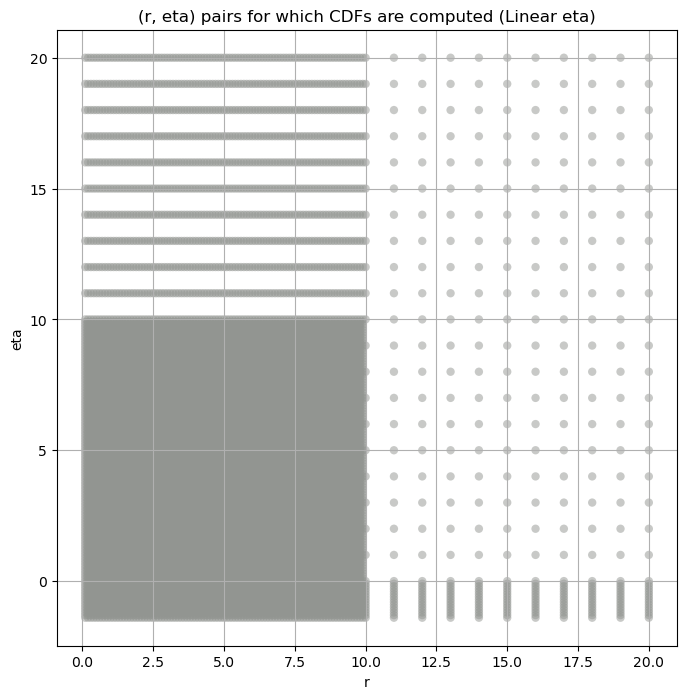

(r,eta),cdf    r  eta  \
0  ((0.1, -1.4), <scipy.interpolate._fitpack2.Int...  0.1 -1.4   
1  ((0.1, -1.3), <scipy.interpolate._fitpack2.Int...  0.1 -1.3   
2  ((0.1, -1.2), <scipy.interpolate._fitpack2.Int...  0.1 -1.2   
3  ((0.1, -1.1), <scipy.interpolate._fitpack2.Int...  0.1 -1.1   
4  ((0.1, -1.0), <scipy.interpolate._fitpack2.Int...  0.1 -1.0   

                                                 cdf      variance  \
0  <scipy.interpolate._fitpack2.InterpolatedUniva...  3.628800e+06   
1  <scipy.interpolate._fitpack2.InterpolatedUniva...  3.991680e+07   
2  <scipy.interpolate._fitpack2.InterpolatedUniva...  2.395008e+08   
3  <scipy.interpolate._fitpack2.InterpolatedUniva...  1.037837e+09   
4  <scipy.interpolate._fitpack2.InterpolatedUniva...  3.632429e+09   

        kurtosis  
0  554265.000000  
1   96192.272727  
2   29390.000000  
3   11997.692308  
4    5874.890110

In [7]:
warnings.filterwarnings('ignore', category=RuntimeWarning)

all_cdfs_df = create_kurt_var_ksstat_df(all_cdfs)
fine_cdfs_df = all_cdfs_df.copy()
all_cdfs_df = all_cdfs_df[(np.round(all_cdfs_df['r'], 1) == all_cdfs_df['r']) & (np.round(all_cdfs_df['eta'], 1) == all_cdfs_df['eta'])]
all_cdfs_df = all_cdfs_df.reset_index(drop=True)
all_cdfs = {x[0] : x[1] for x in all_cdfs_df["(r,eta),cdf"]}
                                             
var_values_dict = dict()
kurt_values_dict = dict()
master_df = pd.DataFrame(columns=[GROUP]).set_index(GROUP)
temp_cdf = all_cdfs_df
print(f"Running {all_cdfs_df.shape[0]} CDFs")
create_scatter_plot(all_cdfs_df);
all_cdfs_df.head()

## Bootstrapping the Variance and Kurtosis

In [8]:
n_bootstrap = int(1e5) # TODO For quick testing purposes
bootstrap_size = int(1e4) # TODO For quick testing purposes
ci = 0.99

In [9]:
bootstrap_path = Path(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))
master_df_var_kurt_path = Path(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))

if RERUN or not master_df_var_kurt_path.exists(): # TODO For quick testing purposes
    for group in GROUPS:
        print(f'{GROUP.capitalize()} {group}')
        obs_var, var_lower, var_upper, var_values_dict[group] = bootstrap_metric(group_data_map[group], 
                                                                                n_bootstrap=n_bootstrap, 
                                                                                bootstrap_size=min(group_data_map[group].size, bootstrap_size), 
                                                                                metric= np.var, 
                                                                                ci=ci)
        obs_kurt, kurt_lower, kurt_upper, kurt_values_dict[group] = bootstrap_metric(group_data_map[group], 
                                                                                    n_bootstrap=n_bootstrap, 
                                                                                    bootstrap_size=min(group_data_map[group].size, bootstrap_size), 
                                                                                    metric= stats.kurtosis, ci=ci)  
        master_df.loc[group, 'obs_var'], master_df.loc[group, 'var_lower'], master_df.loc[group, 'var_upper'] = obs_var, var_lower, var_upper
        master_df.loc[group, 'obs_kurt'], master_df.loc[group, 'kurt_lower'], master_df.loc[group, 'kurt_upper'] = obs_kurt, kurt_lower, kurt_upper
        master_df.loc[group, 'total_samples'] = group_total_samples[group]

    master_df.to_csv(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))

master_df = pd.read_csv(master_df_var_kurt_path, index_col=GROUP)
var_kurt_df = pd.read_csv(bootstrap_path, index_col=GROUP)
master_df

Band 2


100%|██████████| 100000/100000 [00:25<00:00, 3933.66it/s]


Band 5


100%|██████████| 100000/100000 [00:25<00:00, 3996.52it/s]


Band 8


100%|██████████| 100000/100000 [00:25<00:00, 3963.75it/s]


Band 11


100%|██████████| 100000/100000 [00:25<00:00, 3954.41it/s]


Band 14


100%|██████████| 100000/100000 [00:24<00:00, 4034.76it/s]


Band 17


100%|██████████| 100000/100000 [00:24<00:00, 4013.29it/s]


Band 20


100%|██████████| 100000/100000 [00:25<00:00, 3996.79it/s]


Band 23


100%|██████████| 100000/100000 [00:24<00:00, 4003.72it/s]


obs_var    var_lower    var_upper    obs_kurt  kurt_lower  \
band                                                                  
2     1168.482900  1082.486900  1261.638700    6.890563    4.571610   
5      467.177500   422.133970   521.637700   15.030487    7.136231   
8      126.599790   114.962166   140.439400   12.860019    6.715555   
11      29.448475    26.871750    32.462646   11.616289    6.209942   
14       8.483740     7.724014     9.536135   14.224842    6.182292   
17       2.096802     1.867217     2.664229   44.881523    6.934429   
20       0.361453     0.299279     0.666267  406.070500    7.254397   
23       0.083664     0.074874     0.111109   64.435370    4.880280   

       kurt_upper  total_samples  
band                              
2        9.890165        47614.0  
5       30.144716       102030.0  
8       27.600851       326496.0  
11      26.865057       904666.0  
14      52.539310      2727602.0  
17     256.248660      8298440.0  
20    1292.889300     25140192.0  
23     358.102840     65734528.0

## Initial Grid Search and Hypothesis Test Plots

In [10]:
EXCLUDE_CUTOFFS = [0, 25, 50, 75, 100, 150, 200, 250, 300, 350, 500] # TODO For quick testing purposes
SCALE_CAP = 1e5

In [11]:
augmented_var_df_path = Path(os.path.join(CWD, "CSVs", "augmented_var_df.csv"))
augmented_var_df = var_kurt_df[['obs_var']].copy()
augmented_var_df
for val in EXCLUDE_CUTOFFS:
    temp_arr = []
    for group in GROUPS:
        if val != 0:
            temp_arr.append(np.var(group_data_map[group][val:-val]))
        else:
            temp_arr.append(np.var(group_data_map[group]))

    augmented_var_df[f"var_exclude_{val}"] = temp_arr
augmented_var_df

obs_var  var_exclude_0  var_exclude_25  var_exclude_50  \
band                                                               
2     1168.482900    1168.482910     1103.519165     1067.552612   
5      467.177500     467.177490      439.351807      426.372772   
8      126.599790     126.599792      120.095154      116.884003   
11      29.448475      29.448475       28.048096       27.345377   
14       8.483740       8.483740        8.073101        7.877409   
17       2.096802       2.096802        1.950792        1.898563   
20       0.361453       0.361453        0.312110        0.303255   
23       0.083664       0.083664        0.077943        0.076246   

      var_exclude_75  var_exclude_100  var_exclude_150  var_exclude_200  \
band                                                                      
2        1038.464722      1013.867126       972.123596       937.020020   
5         416.424561       408.397278       395.246094       384.246918   
8         114.397163       112.293007       108.725235       105.729225   
11         26.788343        26.317738        25.520342        24.852661   
14          7.721760         7.587990         7.360129         7.167194   
17          1.857609         1.822852         1.764616         1.715772   
20          0.296441         0.290706         0.281166         0.273229   
23          0.074901         0.073748         0.071788         0.070121   

      var_exclude_250  var_exclude_300  var_exclude_350  var_exclude_500  
band                                                                      
2          907.039612       880.720642       857.098206       796.883362  
5          374.849731       366.517944       358.922363       339.320892  
8          103.131836       100.806961        98.682877        93.290413  
11          24.271387        23.749054        23.272135        22.038227  
14           6.997544         6.845226         6.706080         6.345539  
17           1.673007         1.634742         1.599943         1.510555  
20           0.266327         0.260162         0.254566         0.240211  
23           0.068649         0.067320         0.066100         0.062922

####
Band  2


100%|██████████| 12760/12760 [00:24<00:00, 523.51it/s]


Finding Minimum after computing 12760 CDFs
2 0 0.0076118636681482554 1168.4829


100%|██████████| 12760/12760 [00:20<00:00, 620.34it/s]


Finding Minimum after computing 12760 CDFs
2 25 0.007523773747431961 1103.5192


100%|██████████| 12760/12760 [00:20<00:00, 625.45it/s]


Finding Minimum after computing 12760 CDFs
2 50 0.006672092496058726 1067.5526


100%|██████████| 12760/12760 [00:20<00:00, 618.82it/s]


Finding Minimum after computing 12760 CDFs
2 75 0.006306597064759556 1038.4647


100%|██████████| 12760/12760 [00:20<00:00, 617.17it/s]


Finding Minimum after computing 12760 CDFs
2 100 0.006325548592694297 1013.8671


100%|██████████| 12760/12760 [00:20<00:00, 620.94it/s]


Finding Minimum after computing 12760 CDFs
2 150 0.006345097175598946 972.1236


100%|██████████| 12760/12760 [00:20<00:00, 608.92it/s]


Finding Minimum after computing 12760 CDFs
2 200 0.006374980367816141 937.02


100%|██████████| 12760/12760 [00:20<00:00, 621.70it/s]


Finding Minimum after computing 12760 CDFs
2 250 0.00773721802630134 907.0396


100%|██████████| 12760/12760 [00:20<00:00, 626.61it/s]


Finding Minimum after computing 12760 CDFs
2 300 0.008977312880079968 880.72064


100%|██████████| 12760/12760 [00:20<00:00, 617.65it/s]


Finding Minimum after computing 12760 CDFs
2 350 0.010144089830509628 857.0982


100%|██████████| 12760/12760 [00:20<00:00, 624.45it/s]


Finding Minimum after computing 12760 CDFs
2 500 0.01396839594227739 796.88336
Number of samples: 47614, Without approximation : 47614.0


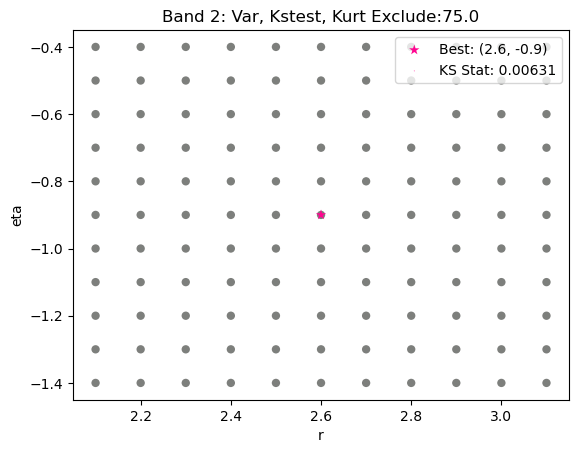

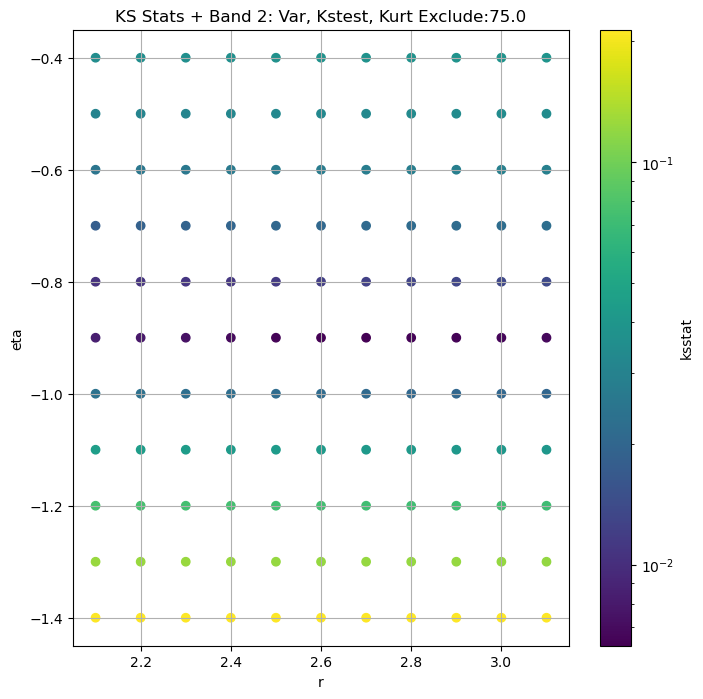

####
Band  5


100%|██████████| 12760/12760 [00:43<00:00, 296.20it/s]


Finding Minimum after computing 12760 CDFs
5 0 0.009243874595763812 467.1775


100%|██████████| 12760/12760 [00:43<00:00, 295.98it/s]


Finding Minimum after computing 12760 CDFs
5 25 0.009893673398011171 439.3518


100%|██████████| 12760/12760 [00:43<00:00, 294.72it/s]


Finding Minimum after computing 12760 CDFs
5 50 0.00952669621723612 426.37277


100%|██████████| 12760/12760 [00:43<00:00, 296.57it/s]


Finding Minimum after computing 12760 CDFs
5 75 0.00946661434957502 416.42456


100%|██████████| 12760/12760 [00:43<00:00, 293.33it/s]


Finding Minimum after computing 12760 CDFs
5 100 0.00826000314702735 408.39728


100%|██████████| 12760/12760 [00:43<00:00, 293.34it/s]


Finding Minimum after computing 12760 CDFs
5 150 0.008226093652837718 395.2461


100%|██████████| 12760/12760 [00:43<00:00, 290.05it/s]


Finding Minimum after computing 12760 CDFs
5 200 0.008318894943484645 384.24692


100%|██████████| 12760/12760 [00:44<00:00, 287.13it/s]


Finding Minimum after computing 12760 CDFs
5 250 0.00839381706935921 374.84973


100%|██████████| 12760/12760 [00:43<00:00, 294.96it/s]


Finding Minimum after computing 12760 CDFs
5 300 0.008427477397140337 366.51794


100%|██████████| 12760/12760 [00:43<00:00, 296.42it/s]


Finding Minimum after computing 12760 CDFs
5 350 0.00827435602509674 358.92236


100%|██████████| 12760/12760 [00:44<00:00, 289.90it/s]


Finding Minimum after computing 12760 CDFs
5 500 0.008344840800080355 339.3209
Number of samples: 100000, Without approximation : 102030.0


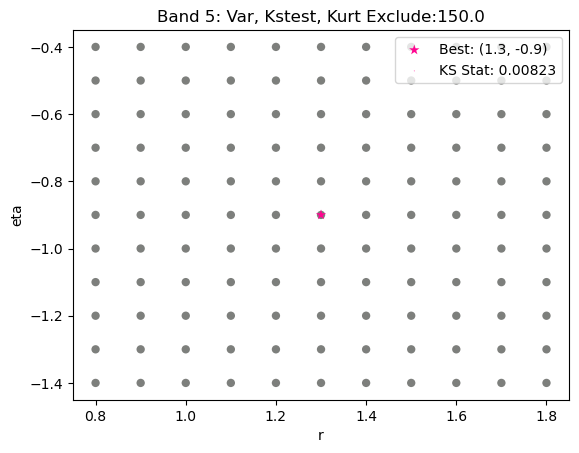

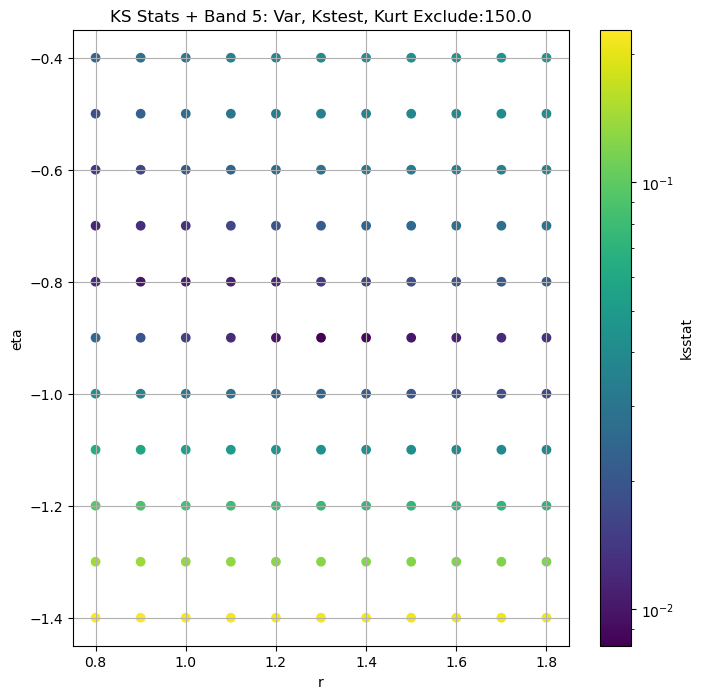

####
Band  8


100%|██████████| 12760/12760 [00:44<00:00, 285.00it/s]


Finding Minimum after computing 12760 CDFs
8 0 0.009390176831212016 126.59979


100%|██████████| 12760/12760 [00:46<00:00, 276.45it/s]


Finding Minimum after computing 12760 CDFs
8 25 0.009018051437768682 120.09515


100%|██████████| 12760/12760 [00:46<00:00, 272.08it/s]


Finding Minimum after computing 12760 CDFs
8 50 0.008778416194530791 116.884


100%|██████████| 12760/12760 [00:46<00:00, 274.02it/s]


Finding Minimum after computing 12760 CDFs
8 75 0.008603786716580464 114.39716


100%|██████████| 12760/12760 [00:45<00:00, 281.11it/s]


Finding Minimum after computing 12760 CDFs
8 100 0.008457099099636545 112.29301


100%|██████████| 12760/12760 [00:46<00:00, 274.88it/s]


Finding Minimum after computing 12760 CDFs
8 150 0.00811357613304653 108.725235


100%|██████████| 12760/12760 [00:46<00:00, 276.56it/s]


Finding Minimum after computing 12760 CDFs
8 200 0.007348571356251998 105.729225


100%|██████████| 12760/12760 [00:46<00:00, 275.89it/s]


Finding Minimum after computing 12760 CDFs
8 250 0.006995409631369576 103.131836


100%|██████████| 12760/12760 [00:45<00:00, 282.56it/s]


Finding Minimum after computing 12760 CDFs
8 300 0.007132211245959863 100.80696


100%|██████████| 12760/12760 [00:44<00:00, 288.64it/s]


Finding Minimum after computing 12760 CDFs
8 350 0.007130320930523237 98.68288


100%|██████████| 12760/12760 [00:44<00:00, 288.89it/s]


Finding Minimum after computing 12760 CDFs
8 500 0.007425808144458146 93.29041
Number of samples: 100000, Without approximation : 326496.0


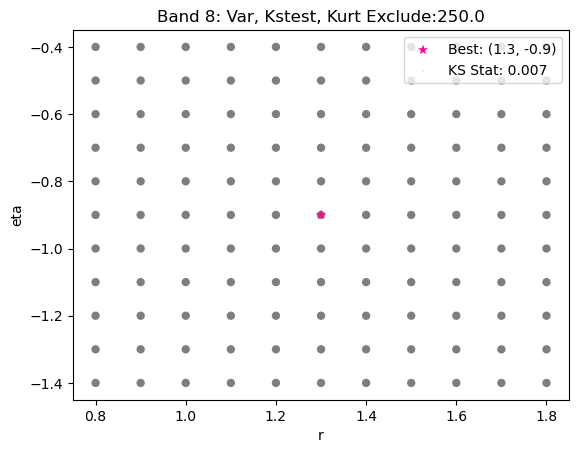

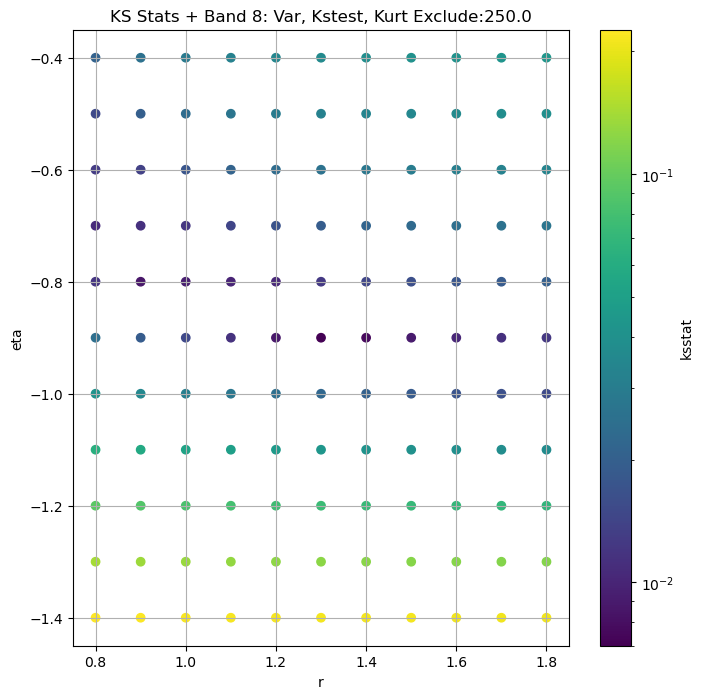

####
Band  11


100%|██████████| 12760/12760 [00:44<00:00, 287.04it/s]


Finding Minimum after computing 12760 CDFs
11 0 0.008488259220497674 29.448475


100%|██████████| 12760/12760 [00:44<00:00, 284.48it/s]


Finding Minimum after computing 12760 CDFs
11 25 0.00799721537667597 28.048096


100%|██████████| 12760/12760 [00:45<00:00, 278.84it/s]


Finding Minimum after computing 12760 CDFs
11 50 0.007760022236776298 27.345377


100%|██████████| 12760/12760 [00:45<00:00, 282.82it/s]


Finding Minimum after computing 12760 CDFs
11 75 0.007572519698944569 26.788343


100%|██████████| 12760/12760 [00:44<00:00, 284.58it/s]


Finding Minimum after computing 12760 CDFs
11 100 0.008188609242512856 26.317738


100%|██████████| 12760/12760 [00:44<00:00, 285.84it/s]


Finding Minimum after computing 12760 CDFs
11 150 0.007620823039809932 25.520342


100%|██████████| 12760/12760 [00:44<00:00, 286.50it/s]


Finding Minimum after computing 12760 CDFs
11 200 0.007108214141195557 24.852661


100%|██████████| 12760/12760 [00:44<00:00, 285.23it/s]


Finding Minimum after computing 12760 CDFs
11 250 0.00663149787939743 24.271387


100%|██████████| 12760/12760 [00:44<00:00, 285.31it/s]


Finding Minimum after computing 12760 CDFs
11 300 0.006414694204856408 23.749054


100%|██████████| 12760/12760 [00:45<00:00, 282.15it/s]


Finding Minimum after computing 12760 CDFs
11 350 0.006396441977260747 23.272135


100%|██████████| 12760/12760 [00:44<00:00, 284.87it/s]


Finding Minimum after computing 12760 CDFs
11 500 0.007544810297760995 22.038227
Number of samples: 100000, Without approximation : 904666.0


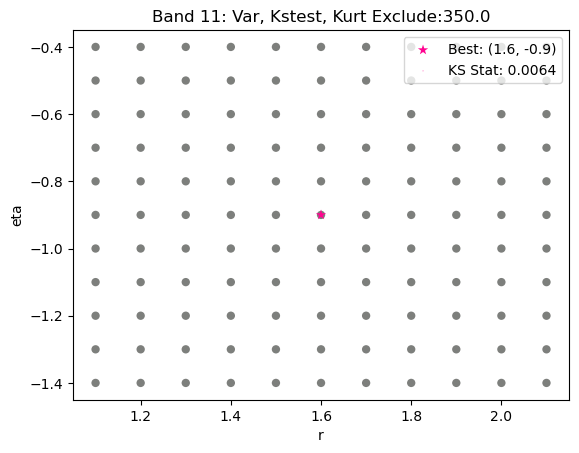

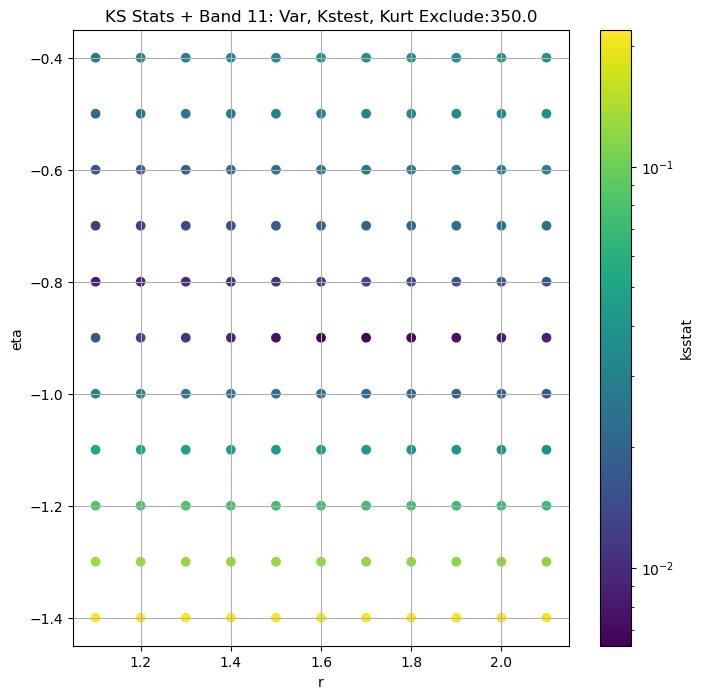

####
Band  14


100%|██████████| 12760/12760 [00:44<00:00, 289.59it/s]


Finding Minimum after computing 12760 CDFs
14 0 0.00800195614464494 8.48374


100%|██████████| 12760/12760 [00:44<00:00, 289.35it/s]


Finding Minimum after computing 12760 CDFs
14 25 0.006596053821720793 8.073101


100%|██████████| 12760/12760 [00:44<00:00, 289.64it/s]


Finding Minimum after computing 12760 CDFs
14 50 0.006715493075025725 7.8774085


100%|██████████| 12760/12760 [00:44<00:00, 286.79it/s]


Finding Minimum after computing 12760 CDFs
14 75 0.006907878590150268 7.7217603


100%|██████████| 12760/12760 [00:44<00:00, 286.19it/s]


Finding Minimum after computing 12760 CDFs
14 100 0.0060618492911547195 7.58799


100%|██████████| 12760/12760 [00:44<00:00, 284.82it/s]


Finding Minimum after computing 12760 CDFs
14 150 0.005709033186588441 7.3601294


100%|██████████| 12760/12760 [00:44<00:00, 287.52it/s]


Finding Minimum after computing 12760 CDFs
14 200 0.006628561016361334 7.167194


100%|██████████| 12760/12760 [00:44<00:00, 284.71it/s]


Finding Minimum after computing 12760 CDFs
14 250 0.006327924479404556 6.997544


100%|██████████| 12760/12760 [00:44<00:00, 289.33it/s]


Finding Minimum after computing 12760 CDFs
14 300 0.00540630277944365 6.845226


100%|██████████| 12760/12760 [00:44<00:00, 288.27it/s]


Finding Minimum after computing 12760 CDFs
14 350 0.006012503204459667 6.70608


100%|██████████| 12760/12760 [00:44<00:00, 288.79it/s]


Finding Minimum after computing 12760 CDFs
14 500 0.007752530158068982 6.3455386
Number of samples: 100000, Without approximation : 2727602.0


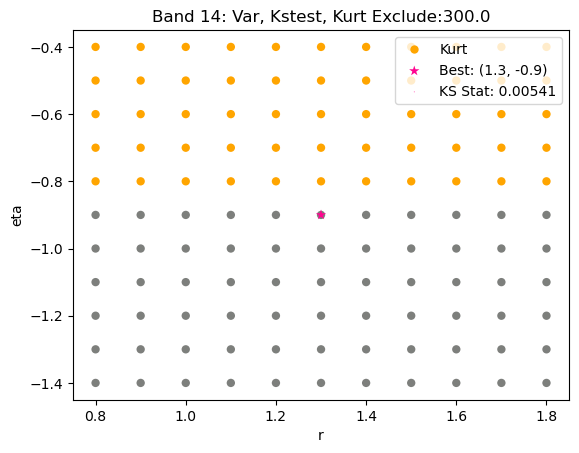

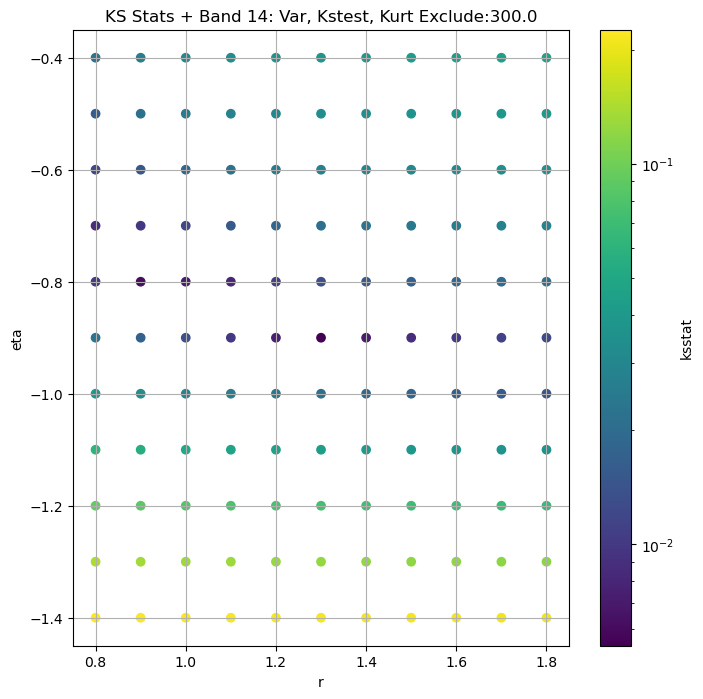

####
Band  17


100%|██████████| 12760/12760 [00:44<00:00, 285.76it/s]


Finding Minimum after computing 12760 CDFs
17 0 0.005513125964220711 2.0968018


100%|██████████| 12760/12760 [00:44<00:00, 285.59it/s]


Finding Minimum after computing 12760 CDFs
17 25 0.006045458293004416 1.950792


100%|██████████| 12760/12760 [00:44<00:00, 286.86it/s]


Finding Minimum after computing 12760 CDFs
17 50 0.005820952313015493 1.8985629


100%|██████████| 12760/12760 [00:44<00:00, 287.31it/s]


Finding Minimum after computing 12760 CDFs
17 75 0.005373684242256038 1.8576093


100%|██████████| 12760/12760 [00:44<00:00, 286.63it/s]


Finding Minimum after computing 12760 CDFs
17 100 0.00499160035496693 1.8228519


100%|██████████| 12760/12760 [00:44<00:00, 288.91it/s]


Finding Minimum after computing 12760 CDFs
17 150 0.00419226983144616 1.7646158


100%|██████████| 12760/12760 [00:44<00:00, 286.92it/s]


Finding Minimum after computing 12760 CDFs
17 200 0.0041332459480400985 1.7157717


100%|██████████| 12760/12760 [00:44<00:00, 284.20it/s]


Finding Minimum after computing 12760 CDFs
17 250 0.004958152210095046 1.6730069


100%|██████████| 12760/12760 [00:44<00:00, 287.79it/s]


Finding Minimum after computing 12760 CDFs
17 300 0.005319952769038849 1.6347424


100%|██████████| 12760/12760 [00:44<00:00, 286.78it/s]


Finding Minimum after computing 12760 CDFs
17 350 0.005909267465507906 1.5999427


100%|██████████| 12760/12760 [00:44<00:00, 287.53it/s]


Finding Minimum after computing 12760 CDFs
17 500 0.0076529275429084165 1.510555
Number of samples: 100000, Without approximation : 8298440.0


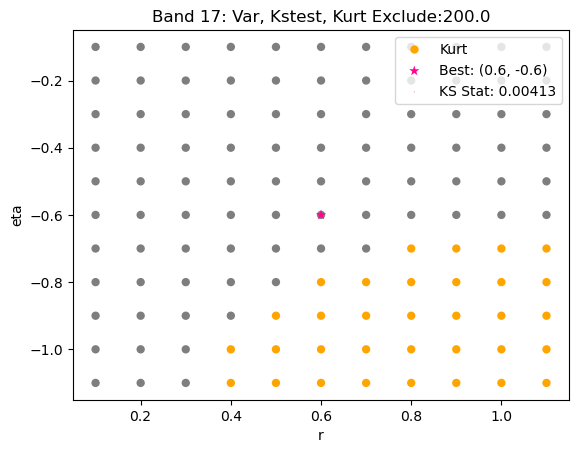

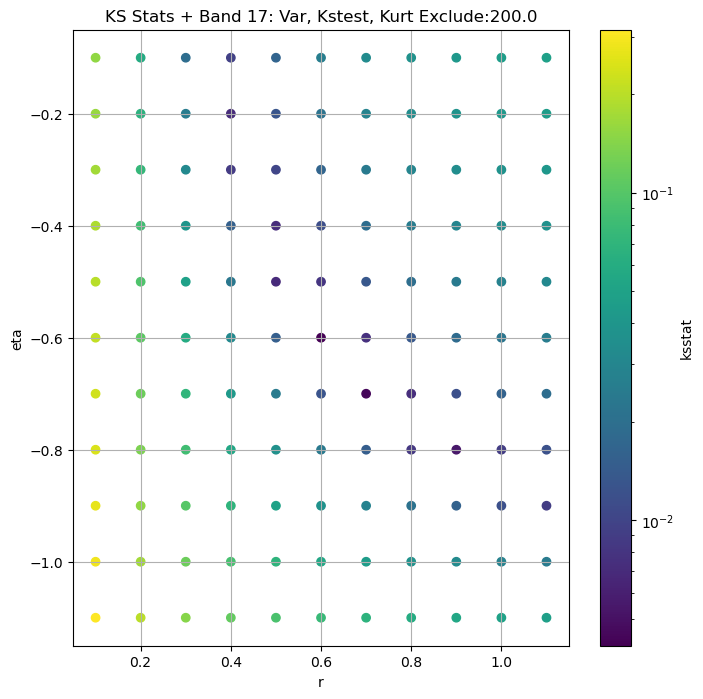

####
Band  20


100%|██████████| 12760/12760 [00:44<00:00, 288.46it/s]


Finding Minimum after computing 12760 CDFs
20 0 0.0038711556778216194 0.36145318


100%|██████████| 12760/12760 [00:44<00:00, 289.62it/s]


Finding Minimum after computing 12760 CDFs
20 25 0.0021380310973841965 0.3121104


100%|██████████| 12760/12760 [00:44<00:00, 289.71it/s]


Finding Minimum after computing 12760 CDFs
20 50 0.0018547013772509668 0.30325526


100%|██████████| 12760/12760 [00:45<00:00, 283.11it/s]


Finding Minimum after computing 12760 CDFs
20 75 0.002515862967086391 0.29644057


100%|██████████| 12760/12760 [00:44<00:00, 288.75it/s]


Finding Minimum after computing 12760 CDFs
20 100 0.0026486250790092036 0.29070622


100%|██████████| 12760/12760 [00:43<00:00, 290.05it/s]


Finding Minimum after computing 12760 CDFs
20 150 0.003337000115334443 0.28116605


100%|██████████| 12760/12760 [00:44<00:00, 285.17it/s]


Finding Minimum after computing 12760 CDFs
20 200 0.0038973584965601438 0.27322897


100%|██████████| 12760/12760 [00:44<00:00, 289.28it/s]


Finding Minimum after computing 12760 CDFs
20 250 0.0045966199953622056 0.26632673


100%|██████████| 12760/12760 [00:44<00:00, 289.11it/s]


Finding Minimum after computing 12760 CDFs
20 300 0.00527934616673531 0.2601616


100%|██████████| 12760/12760 [00:44<00:00, 286.32it/s]


Finding Minimum after computing 12760 CDFs
20 350 0.005823840363527011 0.25456563


100%|██████████| 12760/12760 [00:44<00:00, 285.15it/s]


Finding Minimum after computing 12760 CDFs
20 500 0.007695453538943298 0.24021149
Number of samples: 100000, Without approximation : 25140192.0


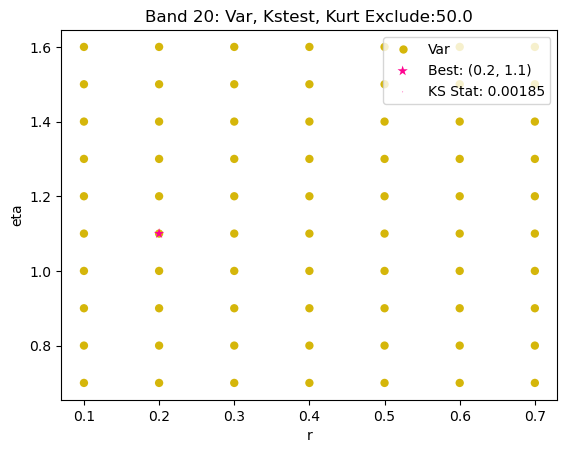

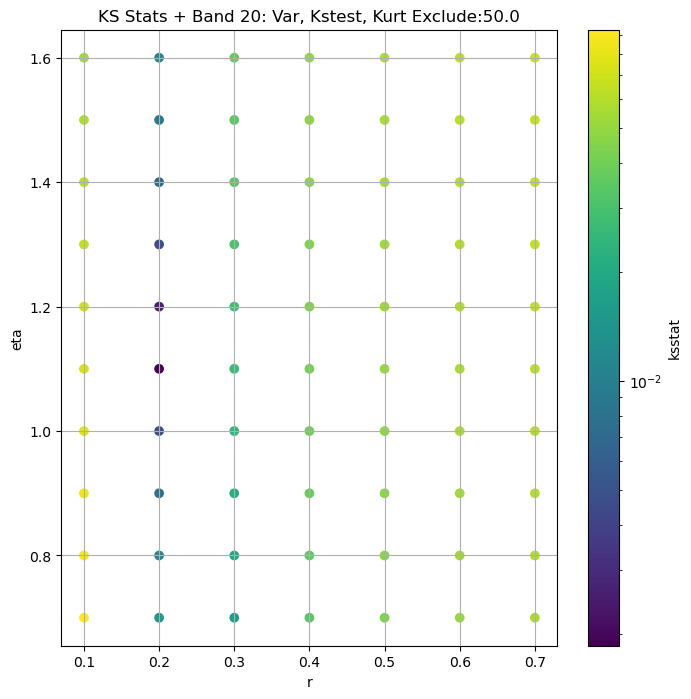

####
Band  23


100%|██████████| 12760/12760 [00:45<00:00, 281.91it/s]


Finding Minimum after computing 12760 CDFs
23 0 0.002272449880716912 0.083664335


100%|██████████| 12760/12760 [00:45<00:00, 281.42it/s]


Finding Minimum after computing 12760 CDFs
23 25 0.001626152496950195 0.077942744


100%|██████████| 12760/12760 [00:44<00:00, 287.14it/s]


Finding Minimum after computing 12760 CDFs
23 50 0.001911269123337167 0.07624585


100%|██████████| 12760/12760 [00:44<00:00, 284.99it/s]


Finding Minimum after computing 12760 CDFs
23 75 0.0022197236539509557 0.07490056


100%|██████████| 12760/12760 [00:44<00:00, 284.35it/s]


Finding Minimum after computing 12760 CDFs
23 100 0.002701821601646448 0.0737484


100%|██████████| 12760/12760 [00:45<00:00, 280.89it/s]


Finding Minimum after computing 12760 CDFs
23 150 0.003418458681235026 0.071787834


100%|██████████| 12760/12760 [00:44<00:00, 284.31it/s]


Finding Minimum after computing 12760 CDFs
23 200 0.0040834959018913874 0.07012102


100%|██████████| 12760/12760 [00:45<00:00, 283.49it/s]


Finding Minimum after computing 12760 CDFs
23 250 0.004727111666024353 0.06864899


100%|██████████| 12760/12760 [00:45<00:00, 282.68it/s]


Finding Minimum after computing 12760 CDFs
23 300 0.005323252583710691 0.06731964


100%|██████████| 12760/12760 [00:44<00:00, 283.66it/s]


Finding Minimum after computing 12760 CDFs
23 350 0.005859415965652204 0.06610044


100%|██████████| 12760/12760 [00:44<00:00, 285.41it/s]


Finding Minimum after computing 12760 CDFs
23 500 0.0075965391091198375 0.062921874
Number of samples: 100000, Without approximation : 65734528.0


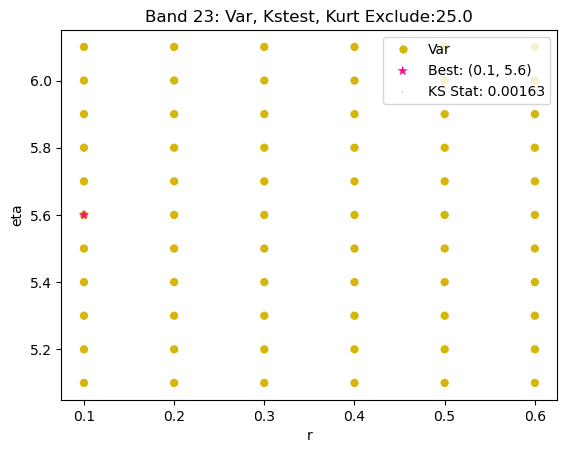

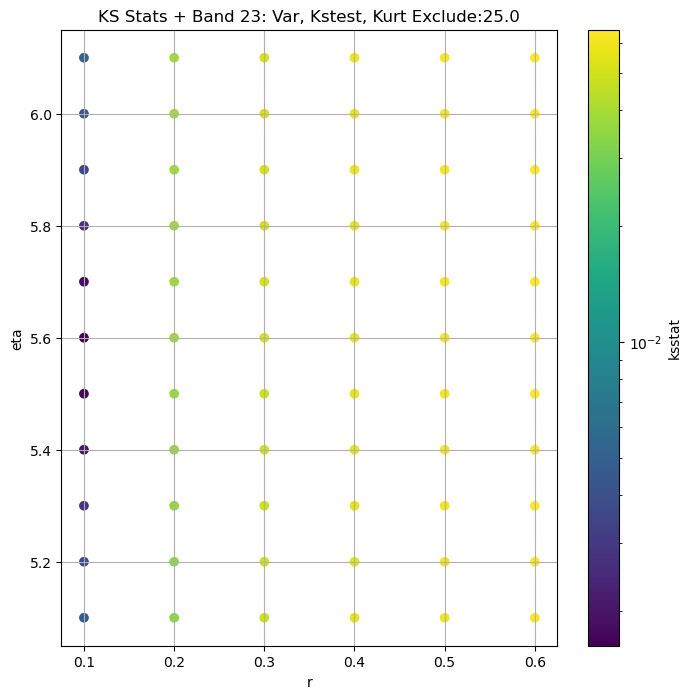

obs_var    var_lower    var_upper    obs_kurt  kurt_lower  \
band                                                                  
2     1168.482900  1082.486900  1261.638700    6.890563    4.571610   
5      467.177500   422.133970   521.637700   15.030487    7.136231   
8      126.599790   114.962166   140.439400   12.860019    6.715555   
11      29.448475    26.871750    32.462646   11.616289    6.209942   
14       8.483740     7.724014     9.536135   14.224842    6.182292   
17       2.096802     1.867217     2.664229   44.881523    6.934429   
20       0.361453     0.299279     0.666267  406.070500    7.254397   
23       0.083664     0.074874     0.111109   64.435370    4.880280   

       kurt_upper  total_samples  kstest_stat_initial  initial_r  initial_eta  \
band                                                                            
2        9.890165        47614.0             0.006307        2.6         -0.9   
5       30.144716       102030.0             0.008226        1.3         -0.9   
8       27.600851       326496.0             0.006995        1.3         -0.9   
11      26.865057       904666.0             0.006396        1.6         -0.9   
14      52.539310      2727602.0             0.005406        1.3         -0.9   
17     256.248660      8298440.0             0.004133        0.6         -0.6   
20    1292.889300     25140192.0             0.001855        0.2          1.1   
23     358.102840     65734528.0             0.001626        0.1          5.6   

      initial_scale  initial_exclude_cutoff  best_augmented_var  \
band                                                              
2      2.816371e+03                    75.0         1038.464700   
5      8.328778e+02                   150.0          395.246100   
8      2.173234e+02                   250.0          103.131836   
11     5.516511e+01                   350.0           23.272135   
14     1.442452e+01                   300.0            6.845226   
17     6.484089e-01                   200.0            1.715772   
20     4.083916e-07                    50.0            0.303255   
23     1.304527e-20                    25.0            0.077943   

      kstest_stat_cutoff_0.05  
band                           
2                    0.006220  
5                    0.004250  
8                    0.002376  
11                   0.001428  
14                   0.000822  
17                   0.000471  
20                   0.000271  
23                   0.000168

In [12]:
master_df_combo_path = Path(os.path.join(CWD, "CSVs", "master_df_combo.csv"))
rEtaKsstats_dict_path = Path(os.path.join(CWD, "cache", "rEtaKsstats_dict.pickle"))

rEtaKsstats_dict = dict()

if RERUN or not master_df_combo_path.exists():
    sorted_params = sorted(all_cdfs)
    ksstats_dict = dict()

    for i, group in enumerate(GROUPS): # TODO For quick testing purposes
        print(f"####\n{GROUP.capitalize()} ", group)
        sample = group_data_map[group]
        group_cdfs_df = all_cdfs_df.copy()
        master_df.loc[group, 'kstest_stat_initial'] = 1

        for j in range(len(EXCLUDE_CUTOFFS)):

            exclude_cutoff = EXCLUDE_CUTOFFS[j]
            exclude_cutoff = int(exclude_cutoff)

            if exclude_cutoff == 0:
                augmented_var = np.var(group_data_map[group]) 
            else:
                augmented_var = np.var(group_data_map[group][exclude_cutoff:-exclude_cutoff])
                if augmented_var == np.var(group_data_map[group]):
                    continue 
                
            group_cdfs_df['scale'] = np.clip((augmented_var / group_cdfs_df['variance']), 0,  SCALE_CAP)
            ksstats, initial_param, min_stat = gridsearch(sample, all_cdfs, debug=True, scales=group_cdfs_df['scale'])
            augmented_var_df.loc[group, f"kstest_stat_{exclude_cutoff}"] = min_stat
            group_cdfs_df[f'ksstat_exclude_{exclude_cutoff}'] = ksstats
            
            print(group, exclude_cutoff, min_stat, augmented_var)
            
            if (min_stat < master_df.loc[group, 'kstest_stat_initial']) and not np.isclose(min_stat, master_df.loc[group, 'kstest_stat_initial'], 1e-6):
                inital_min_stat = min_stat
                inital_best_param = initial_param
                master_df.loc[group, 'kstest_stat_initial'] = min_stat
                initial_scale = group_cdfs_df.loc[(group_cdfs_df["r"] ==  initial_param[0]) & (group_cdfs_df["eta"] ==  initial_param[1])]["scale"].iloc[0]
                master_df.loc[group, 'initial_r'], master_df.loc[group, 'initial_eta'] = initial_param
                master_df.loc[group, 'initial_scale'] = initial_scale
                master_df.loc[group, 'initial_exclude_cutoff'] = exclude_cutoff
                master_df.loc[group, 'best_augmented_var'] = augmented_var
        
        ksstats = group_cdfs_df[f"ksstat_exclude_{int(master_df.loc[group, 'initial_exclude_cutoff'])}"]
            
        print(f"Number of samples: {sample.size}, Without approximation : {master_df.loc[group, 'total_samples']}")
        
        cutoff = stats.kstwo(n=master_df.loc[group, 'total_samples']).isf(0.05)
        master_df.loc[group, 'kstest_stat_cutoff_0.05'] = cutoff

        best_scales = np.clip((master_df.loc[group, 'best_augmented_var'] / group_cdfs_df['variance']), 0,  SCALE_CAP)

        group_cdfs_df['variance'] = group_cdfs_df['variance'] * best_scales
        group_cdfs_df['kurtosis'] = group_cdfs_df['kurtosis'] * best_scales

        group_cdfs_df = add_tests_to_df(cdfs_df = group_cdfs_df, group = group, var_kurt_df = master_df, ksstats = ksstats).sort_values(['r', 'eta'])

        group_dict = {'r' : group_cdfs_df['r'], 'eta' : group_cdfs_df['eta']}
        group_dict.update({f'ksstat_exclude_{exclude_cutoff}' : group_cdfs_df[f'ksstat_exclude_{exclude_cutoff}'] for exclude_cutoff in EXCLUDE_CUTOFFS[:j+1]})
        rEtaKsstats_dict[group] = group_dict

        cols = ['pass_var', 'pass_kstest', 'pass_kurt']

        fig = combo_test_plot(group_cdfs_df, cols, 
                            plot_name=f"{GROUP.capitalize()} {group}: {', '.join([col[5:].capitalize() for col in cols])} Exclude:{master_df.loc[group, 'initial_exclude_cutoff']}", 
                            target_var = None,
                            best_param = inital_best_param,
                            best_ksstat=inital_min_stat
                            )
        
        fig.figure.savefig(os.path.join(CWD, "plots", f"full_grid_search_combo_plot_layer{group}.jpg"), bbox_inches = 'tight', dpi=100)

        # Optional: 
        # Create plots of bootstrapped variance and kurtosis for varying confidence intervals
        # fig_var = create_ci_scatter_plot(group_cdfs_df, var_values_dict, metric='variance', group=group)
        # fig_kurt = create_ci_scatter_plot(group_cdfs_df, kurt_values_dict, metric='kurtosis', group=group)

        # fig_var.savefig(os.path.join(CWD, "plots", f"ci_scatter_variance_{GROUP}_{group}_bootstrap{n_bootstrap}.jpg"), bbox_inches='tight')
        # plt.close(fig_var)
        # fig_kurt.savefig(os.path.join(CWD, "plots", f"ci_scatter_variance_{GROUP}_{group}_bootstrap{n_bootstrap}.jpg"), bbox_inches='tight')
        # plt.close(fig_kurt)

    master_df.to_csv(master_df_combo_path)
    pd.to_pickle(rEtaKsstats_dict, rEtaKsstats_dict_path)
    augmented_var_df.to_csv(augmented_var_df_path)

augmented_var_df = pd.read_csv(augmented_var_df_path, index_col=GROUP)
master_df = pd.read_csv(master_df_combo_path, index_col=GROUP)
rEtaKsstats_dict = pd.read_pickle(rEtaKsstats_dict_path)
master_df

## Optimization

In [13]:
master_df['kstest_stat_best'] = master_df['kstest_stat_initial']
master_df[f'best_r'] = master_df['initial_r']
master_df[f'best_eta'] = master_df['initial_eta']
master_df[f'best_scale'] = master_df['initial_scale']
master_df[f'best_exclude_cutoff'] = master_df['initial_exclude_cutoff']

Band 2


100%|██████████| 180/180 [00:00<00:00, 326.12it/s]


Finding Minimum after computing 180 CDFs
band 2, 75.0 + 100 = 175, ksstat: 0.006915202823920996, var: 953.874755859375


100%|██████████| 180/180 [00:00<00:00, 608.07it/s]


Finding Minimum after computing 180 CDFs
band 2, 75.0 + 75 = 150, ksstat: 0.006833514940356, var: 972.1235961914062


100%|██████████| 180/180 [00:00<00:00, 610.15it/s]


Finding Minimum after computing 180 CDFs
band 2, 75.0 + 50 = 125, ksstat: 0.006583139515833447, var: 992.06103515625


100%|██████████| 180/180 [00:00<00:00, 522.29it/s]


Finding Minimum after computing 180 CDFs
band 2, 75.0 + 25 = 100, ksstat: 0.006325548592694297, var: 1013.8671264648438


100%|██████████| 180/180 [00:00<00:00, 557.31it/s]


Finding Minimum after computing 180 CDFs
band 2, 75.0 + 0 = 75, ksstat: 0.006306597064759556, var: 1038.4647216796875


100%|██████████| 180/180 [00:00<00:00, 633.37it/s]


Finding Minimum after computing 180 CDFs
band 2, 75.0 + -25 = 50, ksstat: 0.006672092496058726, var: 1067.5526123046875


100%|██████████| 180/180 [00:00<00:00, 631.74it/s]


Finding Minimum after computing 180 CDFs
band 2, 75.0 + -50 = 25, ksstat: 0.009219902714253395, var: 1103.5191650390625


100%|██████████| 180/180 [00:00<00:00, 442.78it/s]

Finding Minimum after computing 180 CDFs
band 2, 75.0 + -75 = 0, ksstat: 0.012646531790944826, var: 1168.48291015625
Number of samples: 47614, Without approximation : 47614.0


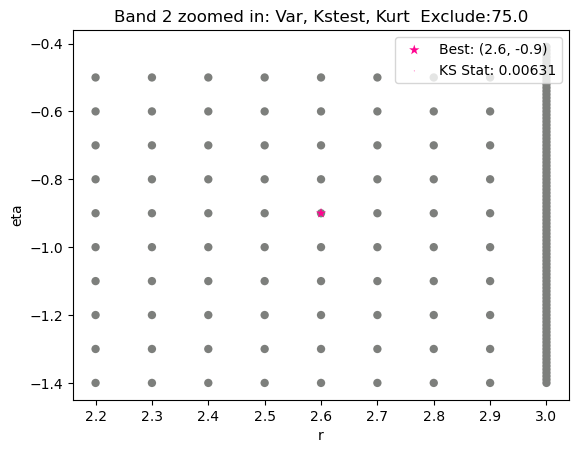

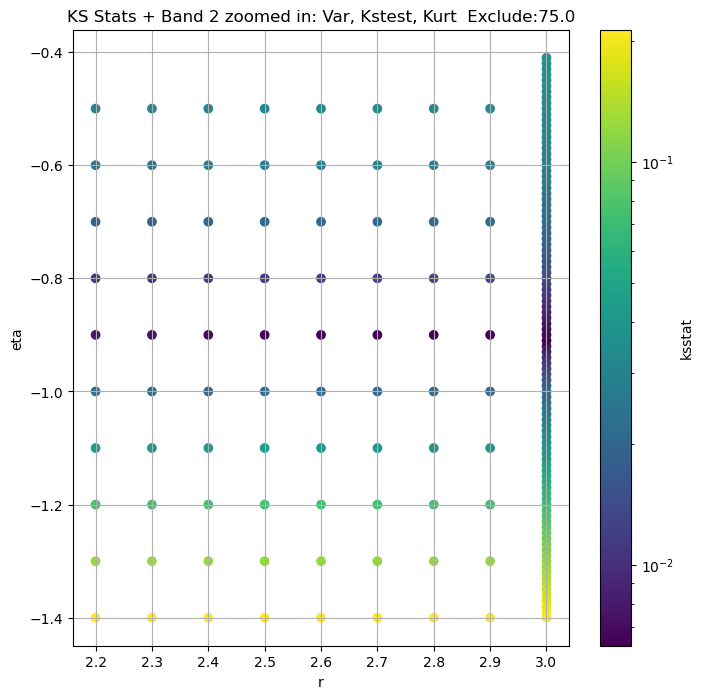

Band 5


100%|██████████| 1800/1800 [00:07<00:00, 246.41it/s]


Finding Minimum after computing 1800 CDFs
band 5, 150.0 + 100 = 250, ksstat: 0.00792192069348846, var: 374.8497314453125


100%|██████████| 1800/1800 [00:06<00:00, 290.56it/s]


Finding Minimum after computing 1800 CDFs
band 5, 150.0 + 75 = 225, ksstat: 0.008004801504570447, var: 379.3807067871094


100%|██████████| 1800/1800 [00:06<00:00, 293.05it/s]


Finding Minimum after computing 1800 CDFs
band 5, 150.0 + 50 = 200, ksstat: 0.007919342414495656, var: 384.2469177246094


100%|██████████| 1800/1800 [00:06<00:00, 283.79it/s]


Finding Minimum after computing 1800 CDFs
band 5, 150.0 + 25 = 175, ksstat: 0.008186125089646945, var: 389.5602722167969


100%|██████████| 1800/1800 [00:06<00:00, 288.81it/s]


Finding Minimum after computing 1800 CDFs
band 5, 150.0 + 0 = 150, ksstat: 0.00819553020060193, var: 395.24609375


100%|██████████| 1800/1800 [00:06<00:00, 287.43it/s]


Finding Minimum after computing 1800 CDFs
band 5, 150.0 + -25 = 125, ksstat: 0.008173953153898128, var: 401.42901611328125


100%|██████████| 1800/1800 [00:06<00:00, 281.00it/s]


Finding Minimum after computing 1800 CDFs
band 5, 150.0 + -50 = 100, ksstat: 0.00826000314702735, var: 408.39727783203125


100%|██████████| 1800/1800 [00:06<00:00, 279.06it/s]


Finding Minimum after computing 1800 CDFs
band 5, 150.0 + -75 = 75, ksstat: 0.0083602185306757, var: 416.424560546875


100%|██████████| 1800/1800 [00:06<00:00, 286.25it/s]


Finding Minimum after computing 1800 CDFs
band 5, 150.0 + -100 = 50, ksstat: 0.008742783266543402, var: 426.3727722167969
Number of samples: 100000, Without approximation : 102030.0


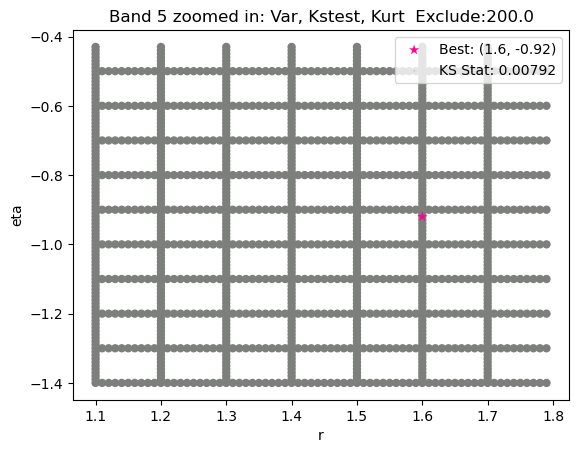

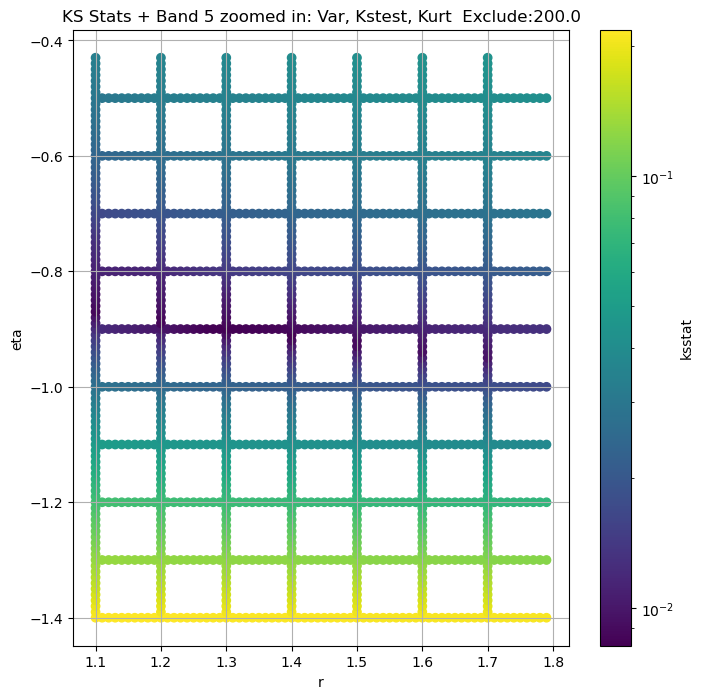

Band 8


100%|██████████| 1800/1800 [00:06<00:00, 276.36it/s]


Finding Minimum after computing 1800 CDFs
band 8, 250.0 + 100 = 350, ksstat: 0.006742791564739337, var: 98.68287658691406


100%|██████████| 1800/1800 [00:06<00:00, 275.44it/s]


Finding Minimum after computing 1800 CDFs
band 8, 250.0 + 75 = 325, ksstat: 0.006627215448788748, var: 99.71832275390625


100%|██████████| 1800/1800 [00:06<00:00, 286.02it/s]


Finding Minimum after computing 1800 CDFs
band 8, 250.0 + 50 = 300, ksstat: 0.006951248624007977, var: 100.80696105957031


100%|██████████| 1800/1800 [00:06<00:00, 285.92it/s]


Finding Minimum after computing 1800 CDFs
band 8, 250.0 + 25 = 275, ksstat: 0.006617629141998038, var: 101.9420394897461


100%|██████████| 1800/1800 [00:06<00:00, 291.17it/s]


Finding Minimum after computing 1800 CDFs
band 8, 250.0 + 0 = 250, ksstat: 0.0068623548514644694, var: 103.1318359375


100%|██████████| 1800/1800 [00:06<00:00, 290.65it/s]


Finding Minimum after computing 1800 CDFs
band 8, 250.0 + -25 = 225, ksstat: 0.006913396173808484, var: 104.38899230957031


100%|██████████| 1800/1800 [00:06<00:00, 289.77it/s]


Finding Minimum after computing 1800 CDFs
band 8, 250.0 + -50 = 200, ksstat: 0.006892706956381334, var: 105.7292251586914


100%|██████████| 1800/1800 [00:06<00:00, 289.89it/s]


Finding Minimum after computing 1800 CDFs
band 8, 250.0 + -75 = 175, ksstat: 0.006874885376656037, var: 107.16741943359375


100%|██████████| 1800/1800 [00:06<00:00, 289.07it/s]


Finding Minimum after computing 1800 CDFs
band 8, 250.0 + -100 = 150, ksstat: 0.007069364178260318, var: 108.72523498535156
Number of samples: 100000, Without approximation : 326496.0


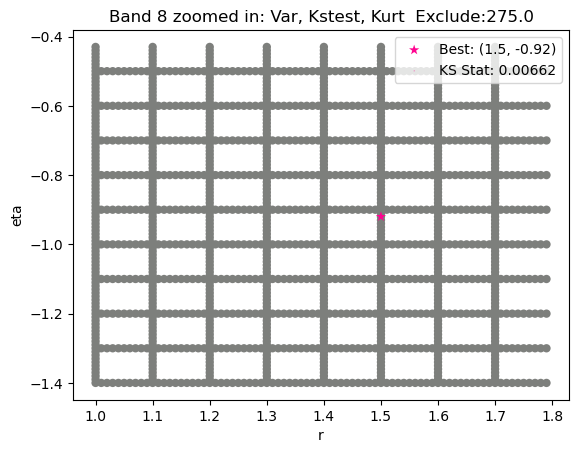

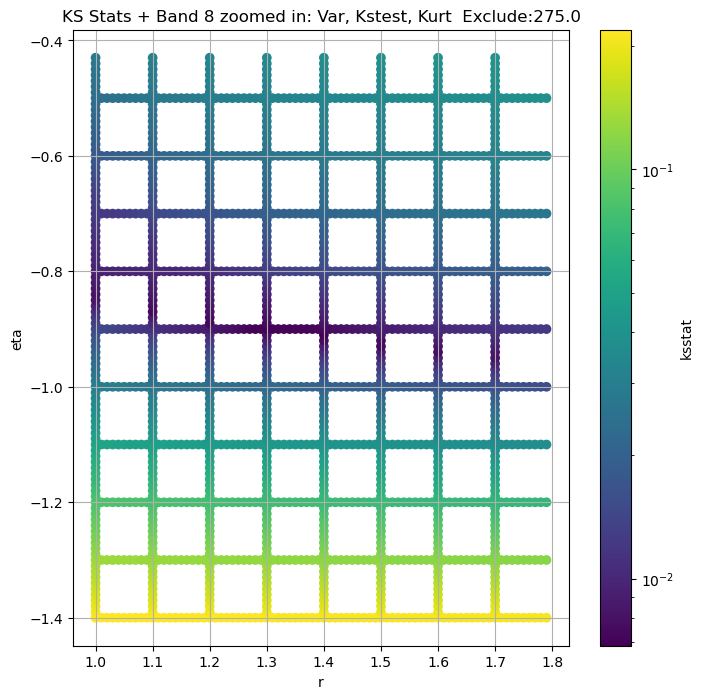

Band 11


100%|██████████| 1710/1710 [00:06<00:00, 265.66it/s]


Finding Minimum after computing 1710 CDFs
band 11, 350.0 + 100 = 450, ksstat: 0.0069264492973653, var: 22.422073364257812


100%|██████████| 1710/1710 [00:05<00:00, 285.41it/s]


Finding Minimum after computing 1710 CDFs
band 11, 350.0 + 75 = 425, ksstat: 0.006677368709585796, var: 22.623905181884766


100%|██████████| 1710/1710 [00:05<00:00, 291.02it/s]


Finding Minimum after computing 1710 CDFs
band 11, 350.0 + 50 = 400, ksstat: 0.0063989413101942505, var: 22.83247184753418


100%|██████████| 1710/1710 [00:05<00:00, 291.54it/s]


Finding Minimum after computing 1710 CDFs
band 11, 350.0 + 25 = 375, ksstat: 0.006236495174236745, var: 23.048093795776367


100%|██████████| 1710/1710 [00:05<00:00, 289.47it/s]


Finding Minimum after computing 1710 CDFs
band 11, 350.0 + 0 = 350, ksstat: 0.006116859231102945, var: 23.27213478088379


100%|██████████| 1710/1710 [00:05<00:00, 290.14it/s]


Finding Minimum after computing 1710 CDFs
band 11, 350.0 + -25 = 325, ksstat: 0.006221116740239063, var: 23.50550651550293


100%|██████████| 1710/1710 [00:05<00:00, 289.34it/s]


Finding Minimum after computing 1710 CDFs
band 11, 350.0 + -50 = 300, ksstat: 0.006351806688755568, var: 23.749053955078125


100%|██████████| 1710/1710 [00:06<00:00, 284.75it/s]


Finding Minimum after computing 1710 CDFs
band 11, 350.0 + -75 = 275, ksstat: 0.006299588391753486, var: 24.003520965576172


100%|██████████| 1710/1710 [00:05<00:00, 288.49it/s]


Finding Minimum after computing 1710 CDFs
band 11, 350.0 + -100 = 250, ksstat: 0.0063153670673695705, var: 24.271387100219727
Number of samples: 100000, Without approximation : 904666.0


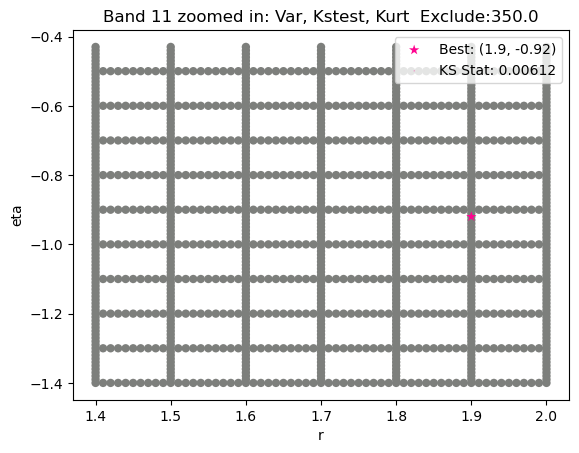

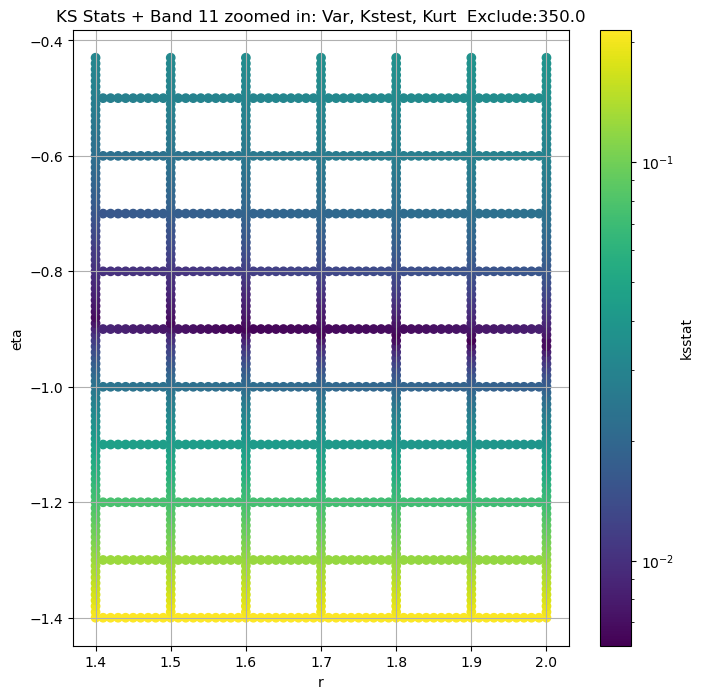

Band 14


100%|██████████| 1800/1800 [00:06<00:00, 288.18it/s]


Finding Minimum after computing 1800 CDFs
band 14, 300.0 + 100 = 400, ksstat: 0.0065401445101525915, var: 6.577517509460449


100%|██████████| 1800/1800 [00:07<00:00, 247.77it/s]


Finding Minimum after computing 1800 CDFs
band 14, 300.0 + 75 = 375, ksstat: 0.006242085034421821, var: 6.640582084655762


100%|██████████| 1800/1800 [00:06<00:00, 284.75it/s]


Finding Minimum after computing 1800 CDFs
band 14, 300.0 + 50 = 350, ksstat: 0.00593749111679754, var: 6.706079959869385


100%|██████████| 1800/1800 [00:06<00:00, 286.14it/s]


Finding Minimum after computing 1800 CDFs
band 14, 300.0 + 25 = 325, ksstat: 0.00563082565895584, var: 6.774194717407227


100%|██████████| 1800/1800 [00:06<00:00, 289.06it/s]


Finding Minimum after computing 1800 CDFs
band 14, 300.0 + 0 = 300, ksstat: 0.005327371602028921, var: 6.845225811004639


100%|██████████| 1800/1800 [00:06<00:00, 287.14it/s]


Finding Minimum after computing 1800 CDFs
band 14, 300.0 + -25 = 275, ksstat: 0.005191282115616702, var: 6.919551849365234


100%|██████████| 1800/1800 [00:06<00:00, 290.56it/s]


Finding Minimum after computing 1800 CDFs
band 14, 300.0 + -50 = 250, ksstat: 0.0049188323282234325, var: 6.997543811798096


100%|██████████| 1800/1800 [00:06<00:00, 279.02it/s]


Finding Minimum after computing 1800 CDFs
band 14, 300.0 + -75 = 225, ksstat: 0.005163515309126621, var: 7.079854488372803


100%|██████████| 1800/1800 [00:06<00:00, 291.52it/s]


Finding Minimum after computing 1800 CDFs
band 14, 300.0 + -100 = 200, ksstat: 0.005304793306536326, var: 7.16719388961792
Number of samples: 100000, Without approximation : 2727602.0


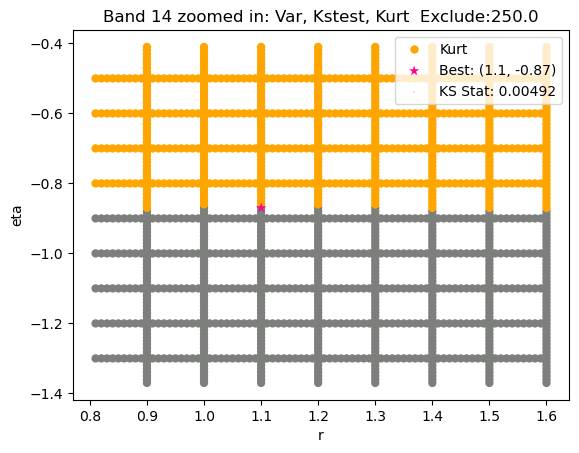

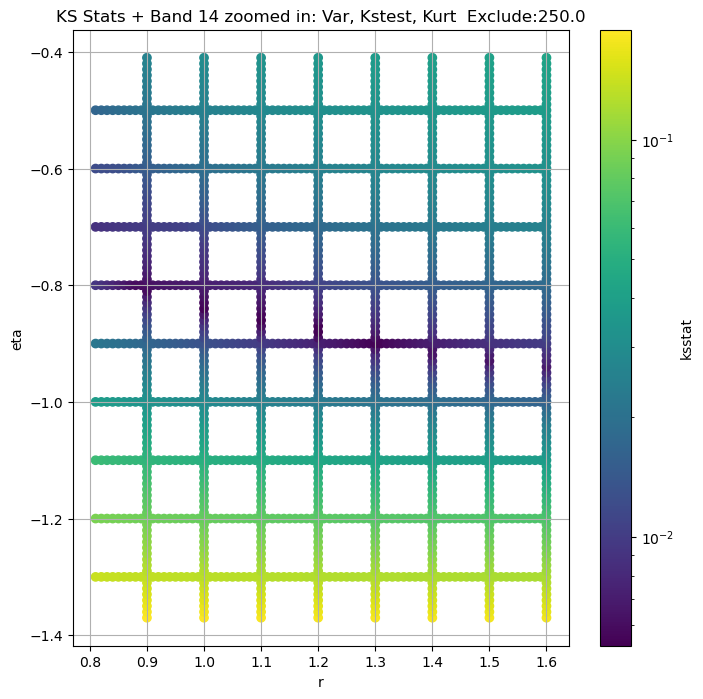

Band 17


100%|██████████| 1701/1701 [00:06<00:00, 263.37it/s]


Finding Minimum after computing 1701 CDFs
band 17, 200.0 + 100 = 300, ksstat: 0.005180932349509448, var: 1.6347423791885376


100%|██████████| 1701/1701 [00:05<00:00, 293.99it/s]


Finding Minimum after computing 1701 CDFs
band 17, 200.0 + 75 = 275, ksstat: 0.004858069815531385, var: 1.6533926725387573


100%|██████████| 1701/1701 [00:05<00:00, 295.92it/s]


Finding Minimum after computing 1701 CDFs
band 17, 200.0 + 50 = 250, ksstat: 0.004540424514688335, var: 1.6730068922042847


100%|██████████| 1701/1701 [00:05<00:00, 298.63it/s]


Finding Minimum after computing 1701 CDFs
band 17, 200.0 + 25 = 225, ksstat: 0.00421338499408519, var: 1.6937540769577026


100%|██████████| 1701/1701 [00:05<00:00, 298.13it/s]


Finding Minimum after computing 1701 CDFs
band 17, 200.0 + 0 = 200, ksstat: 0.0038763645852093465, var: 1.7157716751098633


100%|██████████| 1701/1701 [00:05<00:00, 296.64it/s]


Finding Minimum after computing 1701 CDFs
band 17, 200.0 + -25 = 175, ksstat: 0.0035504214154989944, var: 1.7392805814743042


100%|██████████| 1701/1701 [00:05<00:00, 299.42it/s]


Finding Minimum after computing 1701 CDFs
band 17, 200.0 + -50 = 150, ksstat: 0.003623711235621857, var: 1.764615774154663


100%|██████████| 1701/1701 [00:05<00:00, 296.01it/s]


Finding Minimum after computing 1701 CDFs
band 17, 200.0 + -75 = 125, ksstat: 0.003719508798100346, var: 1.7922511100769043


100%|██████████| 1701/1701 [00:05<00:00, 299.31it/s]


Finding Minimum after computing 1701 CDFs
band 17, 200.0 + -100 = 100, ksstat: 0.0036059515489959004, var: 1.8228518962860107
Number of samples: 100000, Without approximation : 8298440.0


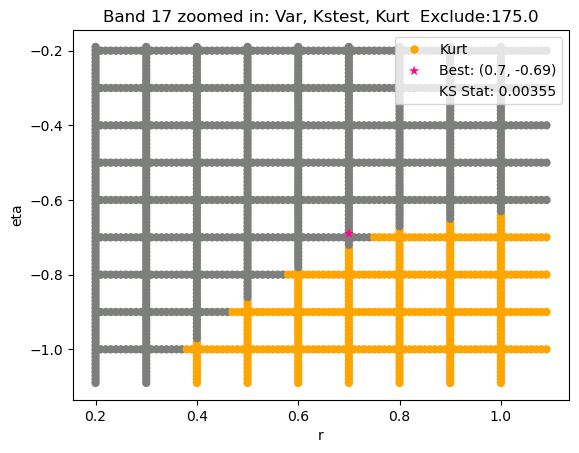

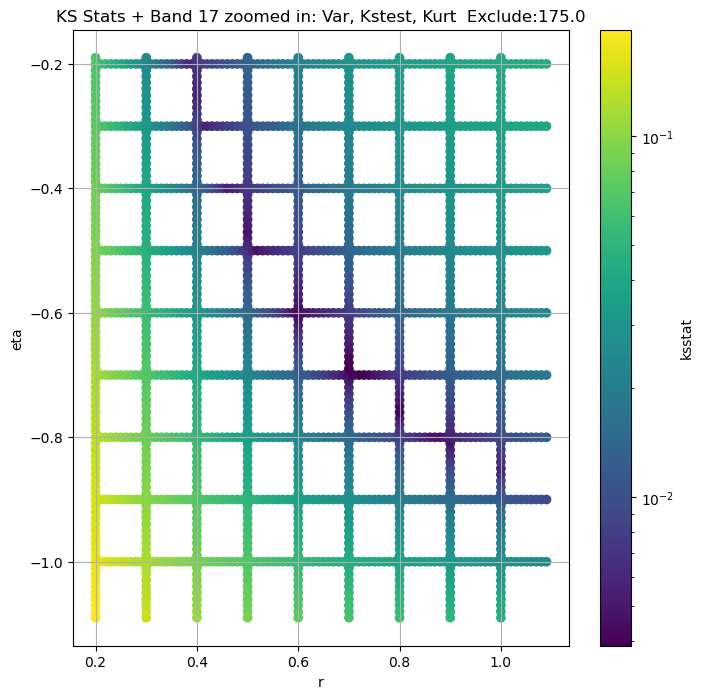

Band 20


100%|██████████| 621/621 [00:02<00:00, 254.62it/s]


Finding Minimum after computing 621 CDFs
band 20, 50.0 + 100 = 150, ksstat: 0.00385060778717905, var: 0.28116604685783386


100%|██████████| 621/621 [00:02<00:00, 299.04it/s]


Finding Minimum after computing 621 CDFs
band 20, 50.0 + 75 = 125, ksstat: 0.0033439322888211276, var: 0.2856796681880951


100%|██████████| 621/621 [00:02<00:00, 299.26it/s]


Finding Minimum after computing 621 CDFs
band 20, 50.0 + 50 = 100, ksstat: 0.0028510606509563052, var: 0.29070621728897095


100%|██████████| 621/621 [00:02<00:00, 298.85it/s]


Finding Minimum after computing 621 CDFs
band 20, 50.0 + 25 = 75, ksstat: 0.002314832288978108, var: 0.29644057154655457


100%|██████████| 621/621 [00:02<00:00, 295.60it/s]


Finding Minimum after computing 621 CDFs
band 20, 50.0 + 0 = 50, ksstat: 0.001775668891757065, var: 0.30325525999069214


100%|██████████| 621/621 [00:02<00:00, 299.55it/s]


Finding Minimum after computing 621 CDFs
band 20, 50.0 + -25 = 25, ksstat: 0.0014385864950204885, var: 0.31211039423942566


100%|██████████| 621/621 [00:02<00:00, 298.94it/s]


Finding Minimum after computing 621 CDFs
band 20, 50.0 + -50 = 0, ksstat: 0.004667148935519533, var: 0.36145317554473877
Number of samples: 100000, Without approximation : 25140192.0


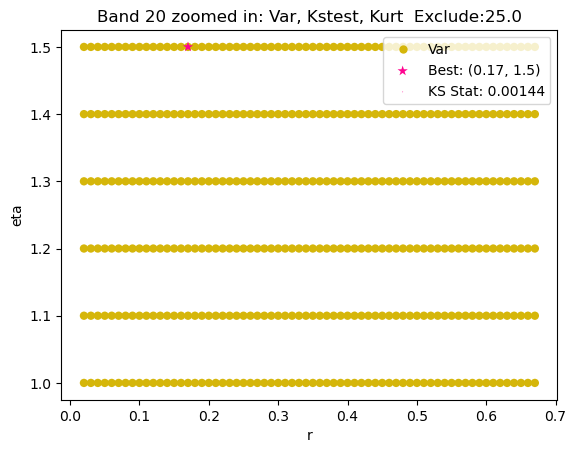

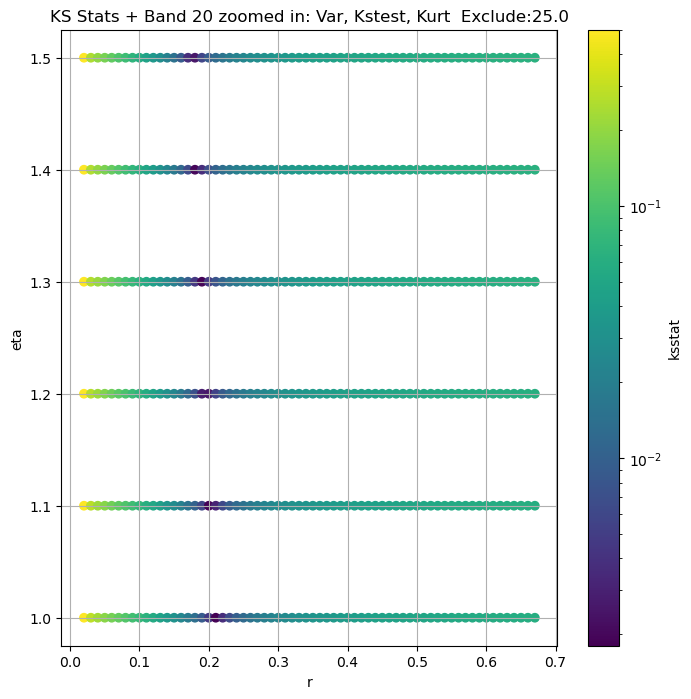

Band 23


100%|██████████| 522/522 [00:02<00:00, 250.10it/s]


Finding Minimum after computing 522 CDFs
band 23, 25.0 + 100 = 125, ksstat: 0.003919449325516022, var: 0.07272214442491531


100%|██████████| 522/522 [00:01<00:00, 274.29it/s]


Finding Minimum after computing 522 CDFs
band 23, 25.0 + 75 = 100, ksstat: 0.003465861973884876, var: 0.0737484022974968


100%|██████████| 522/522 [00:01<00:00, 291.85it/s]


Finding Minimum after computing 522 CDFs
band 23, 25.0 + 50 = 75, ksstat: 0.0029135896687031426, var: 0.0749005600810051


100%|██████████| 522/522 [00:01<00:00, 295.17it/s]


Finding Minimum after computing 522 CDFs
band 23, 25.0 + 25 = 50, ksstat: 0.002312400365695244, var: 0.07624585181474686


100%|██████████| 522/522 [00:01<00:00, 294.59it/s]


Finding Minimum after computing 522 CDFs
band 23, 25.0 + 0 = 25, ksstat: 0.001626152496950195, var: 0.07794274389743805


100%|██████████| 522/522 [00:01<00:00, 286.34it/s]


Finding Minimum after computing 522 CDFs
band 23, 25.0 + -25 = 0, ksstat: 0.002284296336416247, var: 0.08366433531045914
Number of samples: 100000, Without approximation : 65734528.0


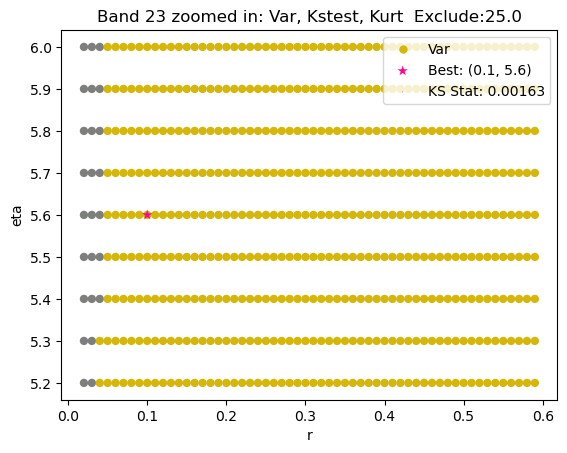

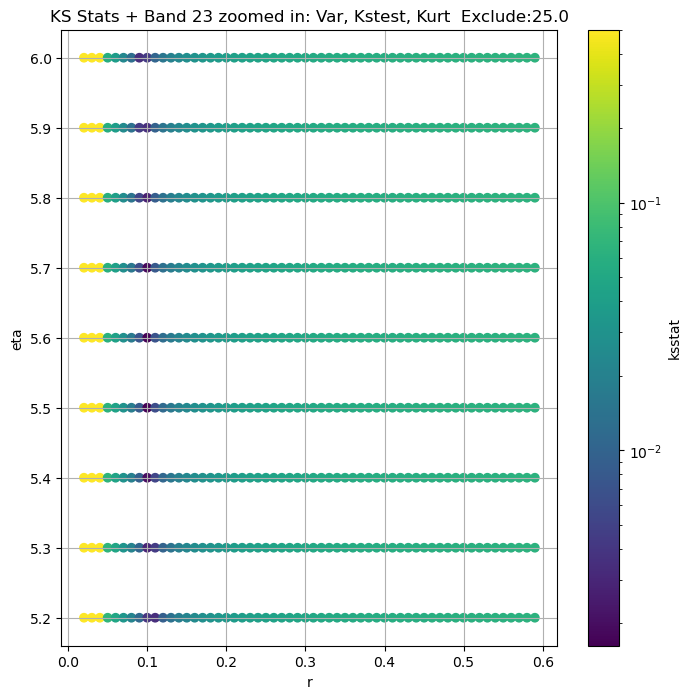

obs_var    var_lower    var_upper    obs_kurt  kurt_lower  \
band                                                                  
2     1168.482900  1082.486900  1261.638700    6.890563    4.571610   
5      467.177500   422.133970   521.637700   15.030487    7.136231   
8      126.599790   114.962166   140.439400   12.860019    6.715555   
11      29.448475    26.871750    32.462646   11.616289    6.209942   
14       8.483740     7.724014     9.536135   14.224842    6.182292   
17       2.096802     1.867217     2.664229   44.881523    6.934429   
20       0.361453     0.299279     0.666267  406.070500    7.254397   
23       0.083664     0.074874     0.111109   64.435370    4.880280   

       kurt_upper  total_samples  kstest_stat_initial  initial_r  initial_eta  \
band                                                                            
2        9.890165        47614.0             0.006307        2.6         -0.9   
5       30.144716       102030.0             0.008226        1.3         -0.9   
8       27.600851       326496.0             0.006995        1.3         -0.9   
11      26.865057       904666.0             0.006396        1.6         -0.9   
14      52.539310      2727602.0             0.005406        1.3         -0.9   
17     256.248660      8298440.0             0.004133        0.6         -0.6   
20    1292.889300     25140192.0             0.001855        0.2          1.1   
23     358.102840     65734528.0             0.001626        0.1          5.6   

      initial_scale  initial_exclude_cutoff  best_augmented_var  \
band                                                              
2      2.816371e+03                    75.0         1038.464700   
5      8.328778e+02                   150.0          384.246918   
8      2.173234e+02                   250.0          101.942039   
11     5.516511e+01                   350.0           23.272135   
14     1.442452e+01                   300.0            6.997544   
17     6.484089e-01                   200.0            1.739281   
20     4.083916e-07                    50.0            0.312110   
23     1.304527e-20                    25.0            0.077943   

      kstest_stat_cutoff_0.05  kstest_stat_best  best_r  best_eta  \
band                                                                
2                    0.006220          0.006307    2.60     -0.90   
5                    0.004250          0.007919    1.60     -0.92   
8                    0.002376          0.006618    1.50     -0.92   
11                   0.001428          0.006117    1.90     -0.92   
14                   0.000822          0.004919    1.10     -0.87   
17                   0.000471          0.003550    0.70     -0.69   
20                   0.000271          0.001439    0.17      1.50   
23                   0.000168          0.001626    0.10      5.60   

        best_scale  best_exclude_cutoff  n_pval_0.05  
band                                                  
2     2.816371e+03                 75.0      47614.0  
5     9.364447e+02                200.0      28695.0  
8     2.409038e+02                275.0      40812.0  
11    6.046584e+01                350.0      47704.0  
14    1.228633e+01                250.0      76794.0  
17    1.144466e+00                175.0     145870.0  
20    6.900204e-09                 25.0     883834.0  
23    1.304527e-20                 25.0     731206.0

In [14]:
master_df_optimized_path = Path(os.path.join(CWD, "CSVs", 'master_df_optimized.csv'))

NUM_ITERS = dict(zip(GROUPS, [1]*len(GROUPS))) # By default, does one iteration per group
NUM_SAMPLES_OPTIMIZE = 2000
EXCLUDE_CUTOFFS_OPTIMIZE = np.arange(100, -101, -25)

if RERUN or not master_df_optimized_path.exists():

    if SKIP_OPTIMIZE_STEP:

        master_df['kstest_stat_best'] = master_df['kstest_stat_initial']
        master_df[f'best_r'] = master_df['initial_r']
        master_df[f'best_eta'] = master_df['initial_eta']
        master_df[f'best_scale'] = master_df['initial_scale']
        master_df[f'best_exclude_cutoff'] = master_df['initial_exclude_cutoff']

    else:
        for group in GROUPS: # TODO For quick testing purposes
            print(f"{GROUP.capitalize()} {group}")
            master_df.loc[group, 'kstest_stat_best'] = master_df.loc[group, 'kstest_stat_initial']
            master_df.loc[group, 'best_r'] = master_df.loc[group, 'initial_r']
            master_df.loc[group, 'best_eta'] = master_df.loc[group, 'initial_eta']
            master_df.loc[group, 'best_scale'] = master_df.loc[group, 'initial_scale']

            sample = group_data_map[group]
            initial_r, initial_eta = master_df.loc[group, 'initial_r'], master_df.loc[group, f'initial_eta']
            eps = 0.5
            group_cdfs_df = fine_cdfs_df[(np.abs(master_df.loc[group, 'initial_r'] - fine_cdfs_df['r']) < eps) & 
                                        (np.abs(master_df.loc[group, 'initial_eta'] - fine_cdfs_df['eta']) < eps)].reset_index(drop=True)
            group_cdfs = {x[0]:x[1] for x in group_cdfs_df['(r,eta),cdf']}

            for adjust_exclude_cutoff in EXCLUDE_CUTOFFS_OPTIMIZE: # -50, -25, 0, 25, 50
                
                exclude_cutoff = int(max(0, adjust_exclude_cutoff + master_df.loc[group, 'initial_exclude_cutoff']))
                
                if exclude_cutoff == 0:
                    augmented_var = np.var(group_data_map[group])
                else:
                    augmented_var = np.var(group_data_map[group][exclude_cutoff:-exclude_cutoff])                       

                group_cdfs_df['scale'] = np.clip((augmented_var / group_cdfs_df['variance']), 0,  SCALE_CAP)
                ksstats, initial_param, min_stat = gridsearch(sample, group_cdfs, debug=True, scales=group_cdfs_df['scale'])
                
                cutoff_label = generate_cutoff_label(adjust_exclude_cutoff)

                augmented_var_df.loc[group, f"kstest_stat_{cutoff_label}"] = min_stat
                group_cdfs_df[f'ksstat_exclude_{cutoff_label}'] = ksstats
                
                print(f"{GROUP} {group}, {master_df.loc[group, 'initial_exclude_cutoff']} + {adjust_exclude_cutoff} = {exclude_cutoff}, ksstat: {min_stat}, var: {augmented_var}")
                best_adjust = 0

                if min_stat < master_df.loc[group, 'kstest_stat_best']:

                    inital_min_stat = min_stat
                    inital_best_param = initial_param
                    master_df.loc[group, 'kstest_stat_best'] = min_stat
                    initial_scale = group_cdfs_df.loc[(group_cdfs_df["r"] ==  initial_param[0]) & (group_cdfs_df["eta"] ==  initial_param[1])]["scale"].iloc[0]
                    master_df.loc[group, 'best_r'], master_df.loc[group, 'best_eta'] = initial_param
                    master_df.loc[group, 'best_scale'] = initial_scale
                    master_df.loc[group, 'best_exclude_cutoff'] = exclude_cutoff
                    master_df.loc[group, 'best_augmented_var'] = augmented_var
                    augmented_var_df.loc[group, 'best_augmented_var'] = augmented_var
                    best_adjust = adjust_exclude_cutoff

                if exclude_cutoff == 0:
                    break

            cutoff_label = generate_cutoff_label(best_adjust)
            ksstats = group_cdfs_df[f"ksstat_exclude_{cutoff_label}"]
            
            print(f"Number of samples: {sample.size}, Without approximation : {master_df.loc[group, 'total_samples']}")
            
            cutoff = stats.kstwo(n=master_df.loc[group, 'total_samples']).isf(0.05)
            master_df.loc[group, 'kstest_stat_cutoff_0.05'] = cutoff

            best_scales = np.clip((master_df.loc[group, 'best_augmented_var'] / group_cdfs_df['variance']), 0,  SCALE_CAP)

            group_cdfs_df['variance'] = group_cdfs_df['variance'] * best_scales
            group_cdfs_df['kurtosis'] = group_cdfs_df['kurtosis'] * best_scales

            group_cdfs_df = add_tests_to_df(cdfs_df = group_cdfs_df, group = group, var_kurt_df = master_df, ksstats = ksstats).sort_values(['r', 'eta'])

            group_dict = rEtaKsstats_dict[group]
            group_dict.update({'r_optimize' : group_cdfs_df['r'], 'eta_optimize' : group_cdfs_df['eta'], f'ksstat_exclude_{cutoff_label}' : ksstats})
            rEtaKsstats_dict[group] = group_dict

            cols = ['pass_var', 'pass_kstest', 'pass_kurt']
            fig = combo_test_plot(group_cdfs_df, cols, 
                                plot_name=f"{GROUP.capitalize()} {group} zoomed in: {', '.join([col[5:].capitalize() for col in cols])}  Exclude:{master_df.loc[group, 'best_exclude_cutoff']}",
                                best_param=(master_df.loc[group, 'best_r'], master_df.loc[group, f'best_eta']),
                                best_ksstat=master_df.loc[group, 'kstest_stat_best'])
            fig.figure.savefig(os.path.join(CWD, "plots", f"optimized_full_grid_search_combo_plot_layer{group}.jpg"), bbox_inches = 'tight', dpi=100)
            
    master_df['n_pval_0.05'] = master_df.apply(lambda row : find_n_fixed_pval_stat(row.loc['kstest_stat_best'], row.loc['total_samples']), axis = 1)    
    master_df[['total_samples', 'initial_r', 'initial_eta', 'kstest_stat_initial', 'initial_exclude_cutoff', 'best_r', 'best_eta', 'best_scale', 'kstest_stat_best', 'best_exclude_cutoff', 'n_pval_0.05']].to_csv(os.path.join(CWD, "CSVs", 'optimized_params.csv'))
    master_df.to_csv(os.path.join(CWD, "CSVs", 'master_df_optimized.csv'))
    augmented_var_df.to_csv(augmented_var_df_path)
    pd.to_pickle(rEtaKsstats_dict, rEtaKsstats_dict_path)

rEtaKsstats_dict = pd.read_pickle(rEtaKsstats_dict_path)
master_df = pd.read_csv(master_df_optimized_path, index_col = GROUP)
augmented_var_df = pd.read_csv(augmented_var_df_path, index_col = GROUP)
master_df

## Comparing Empirical and Computed CDF/PDF

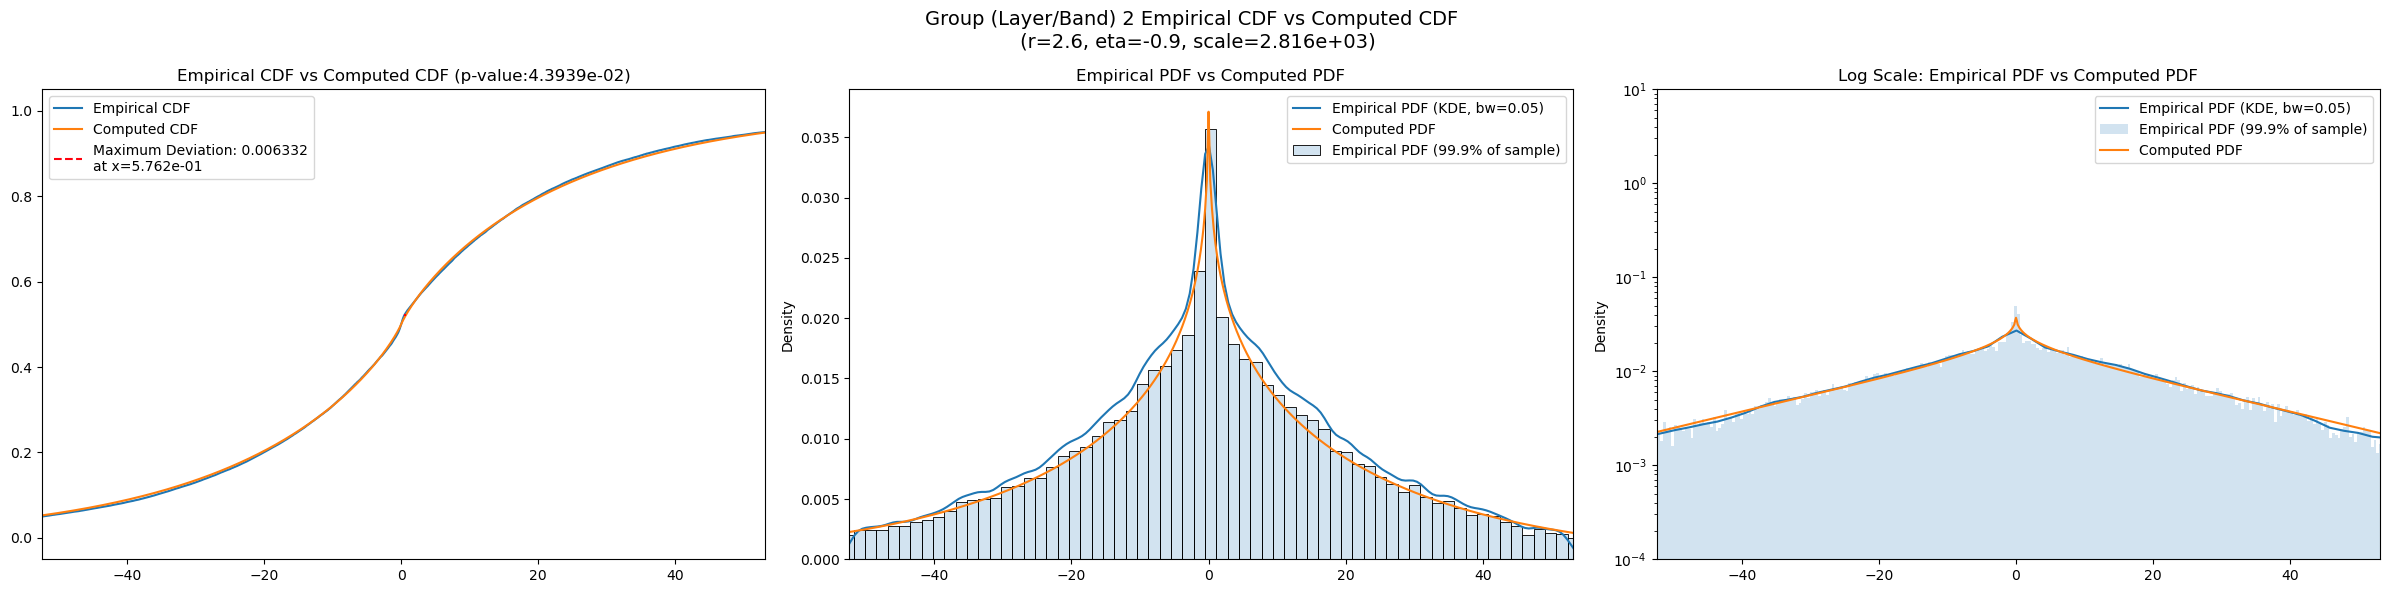

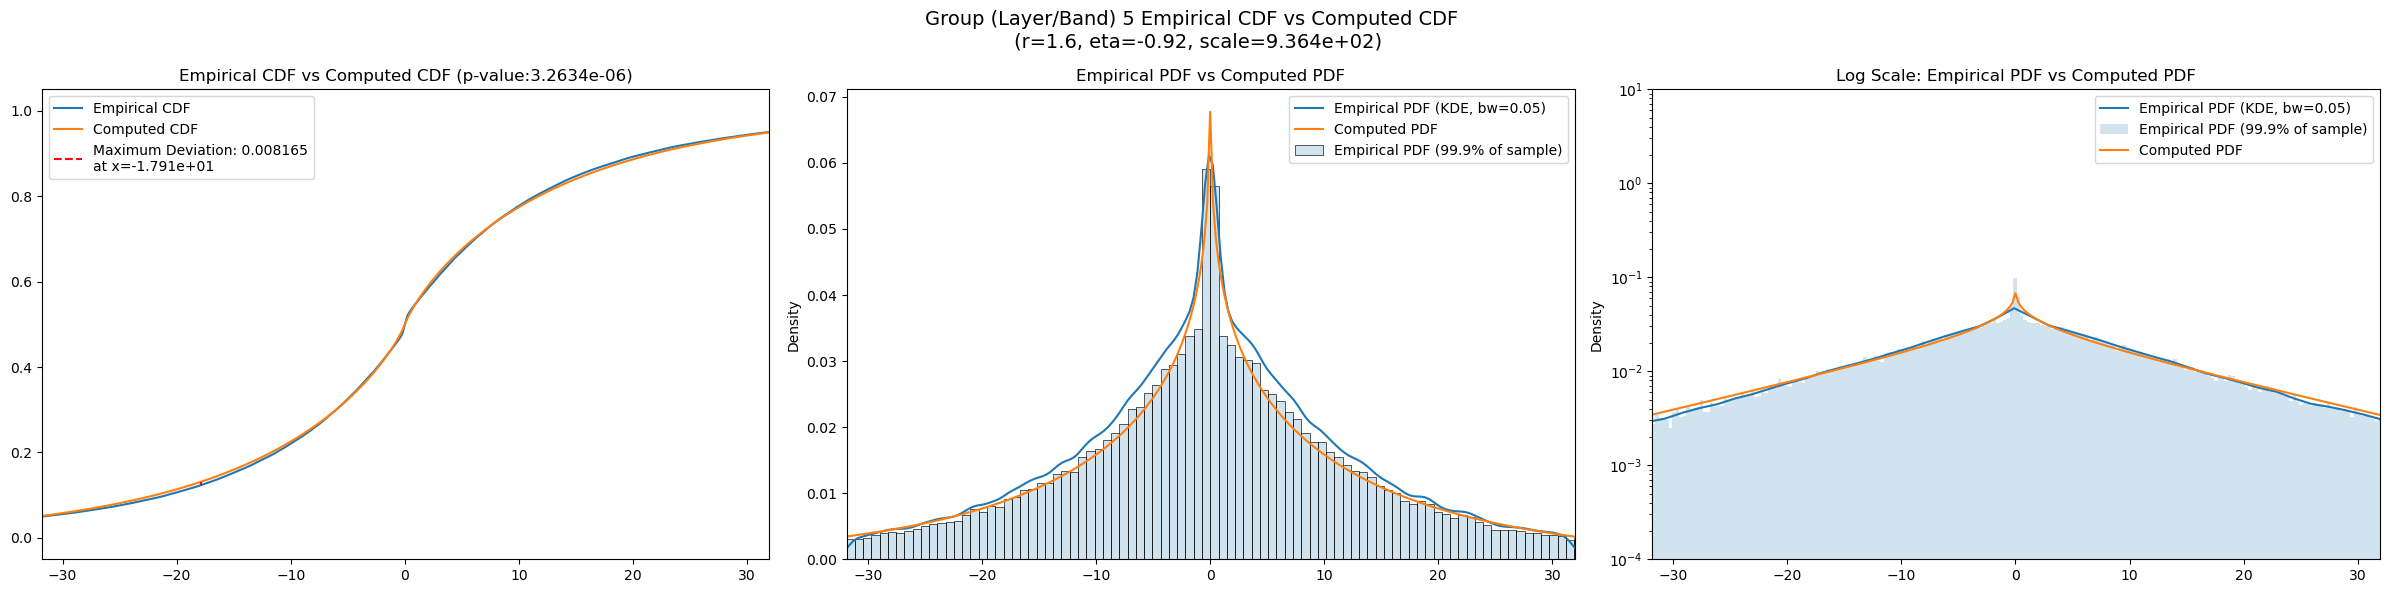

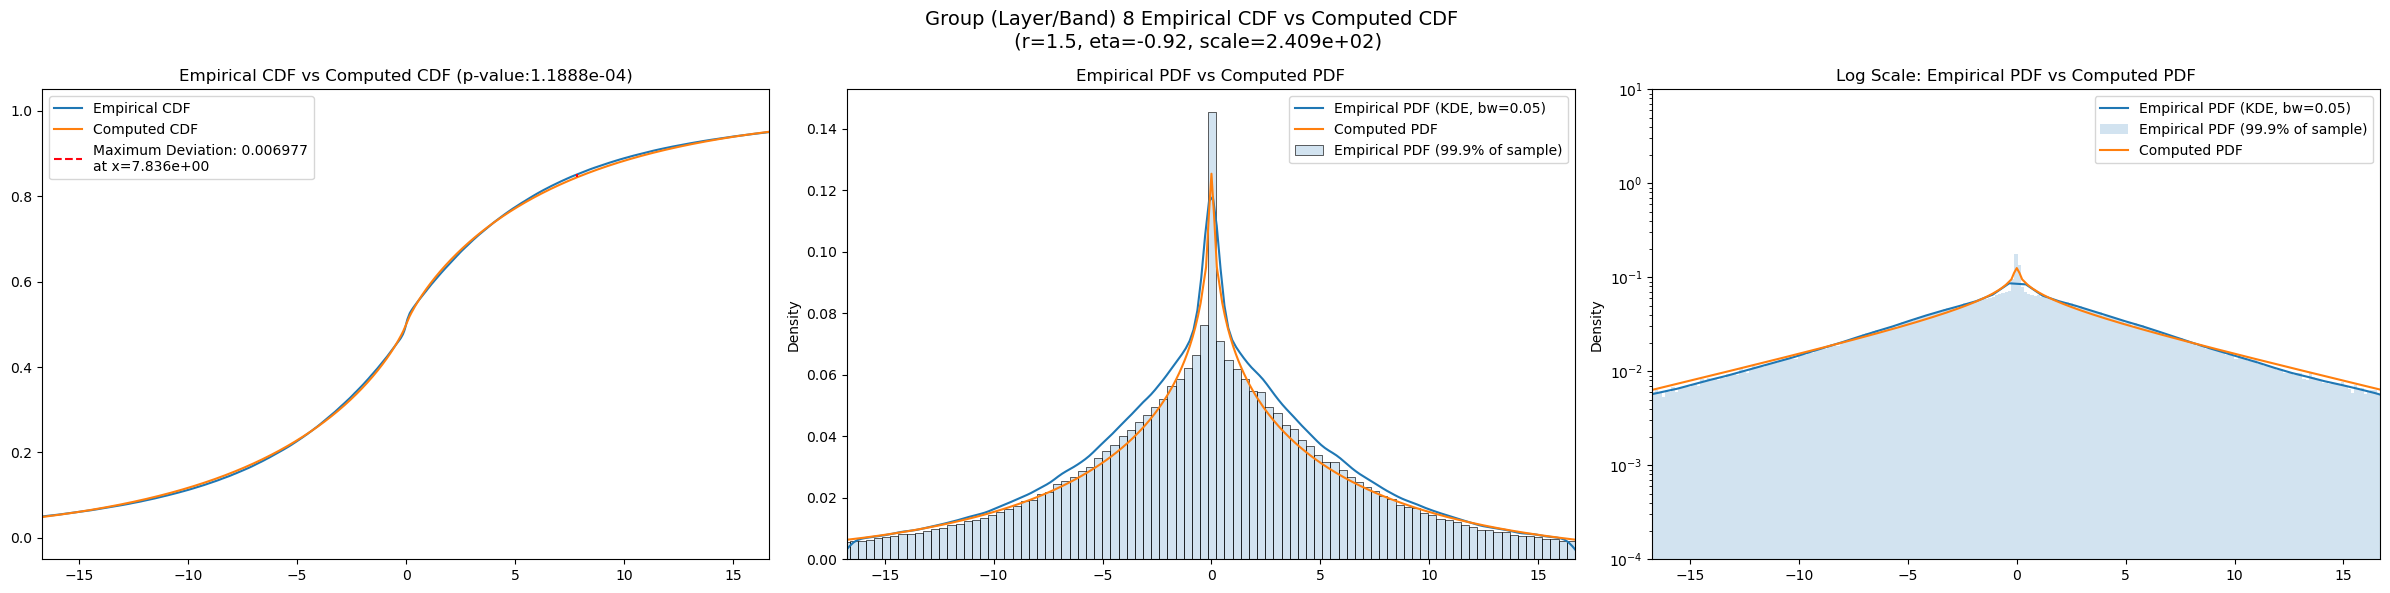

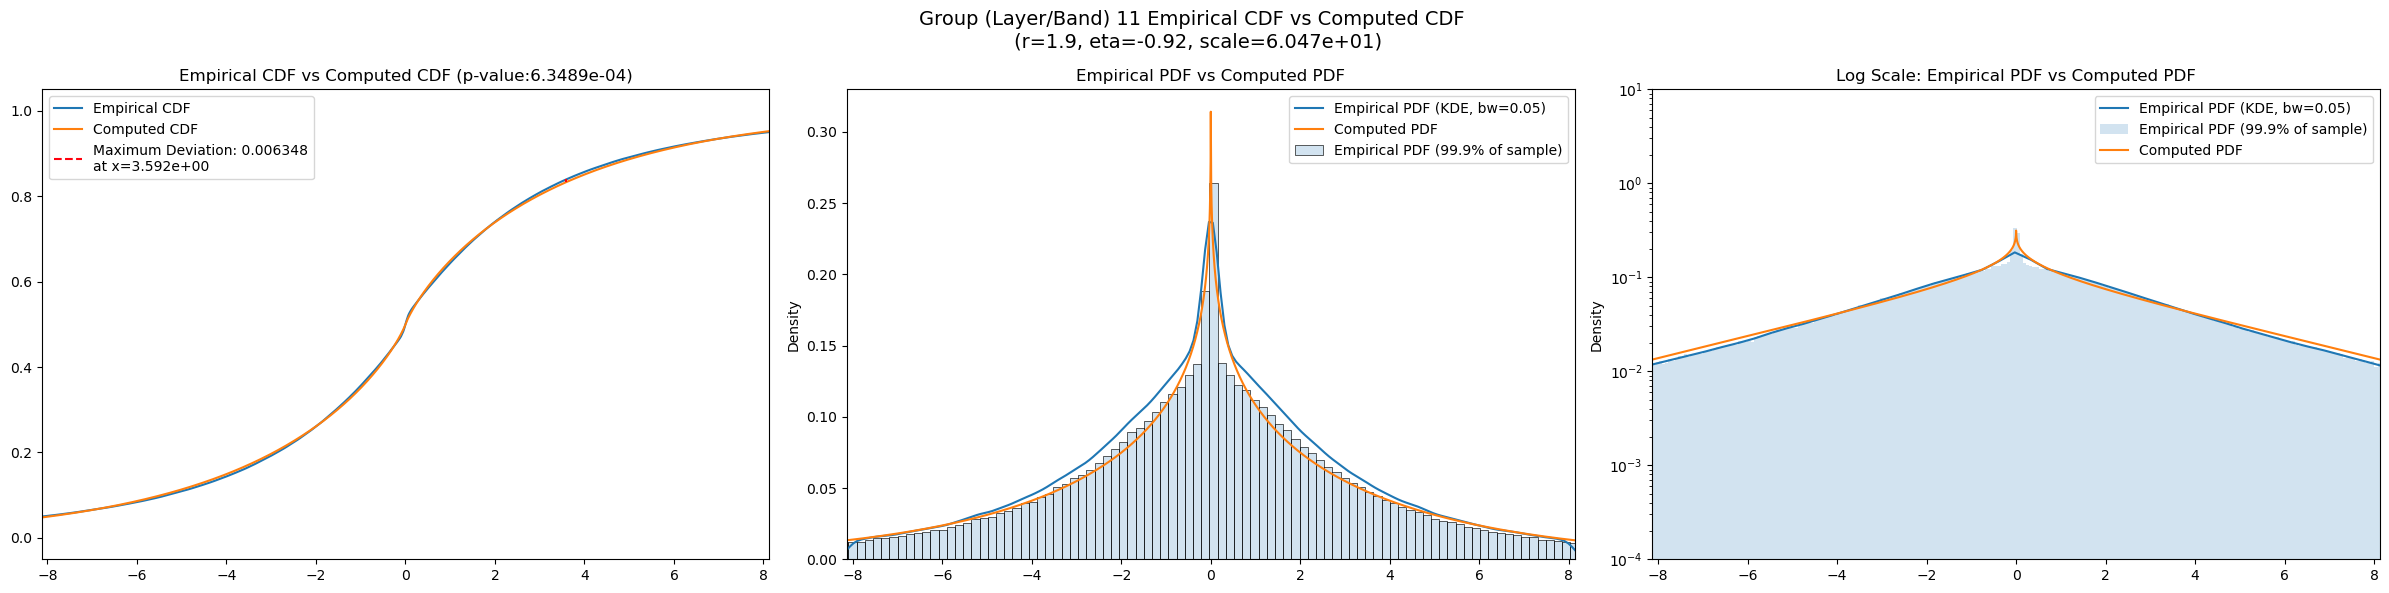

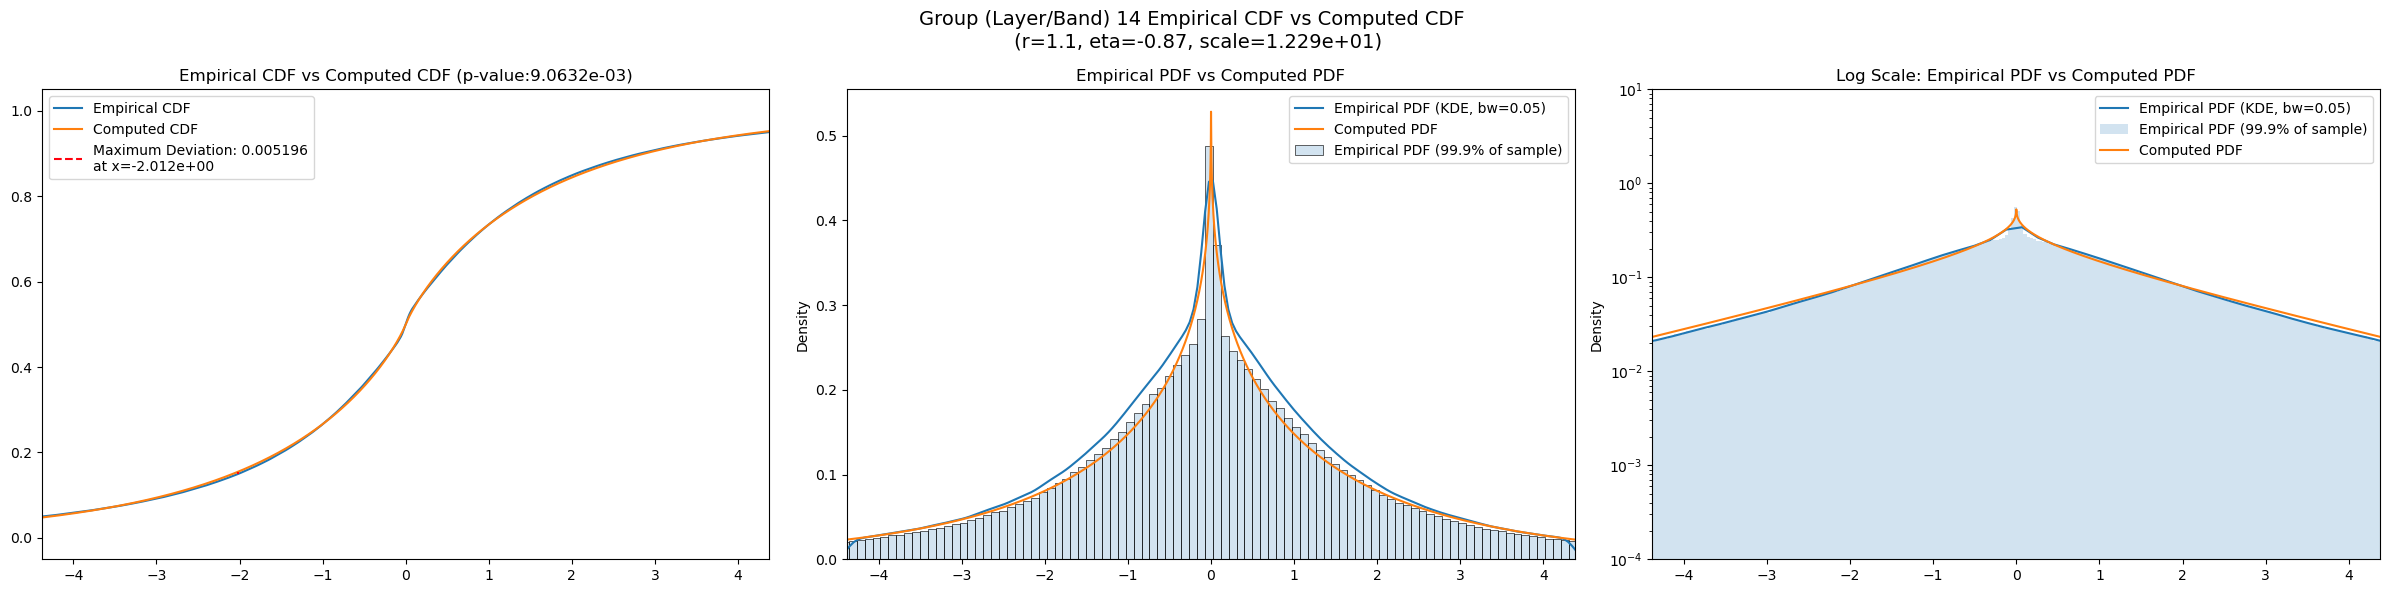

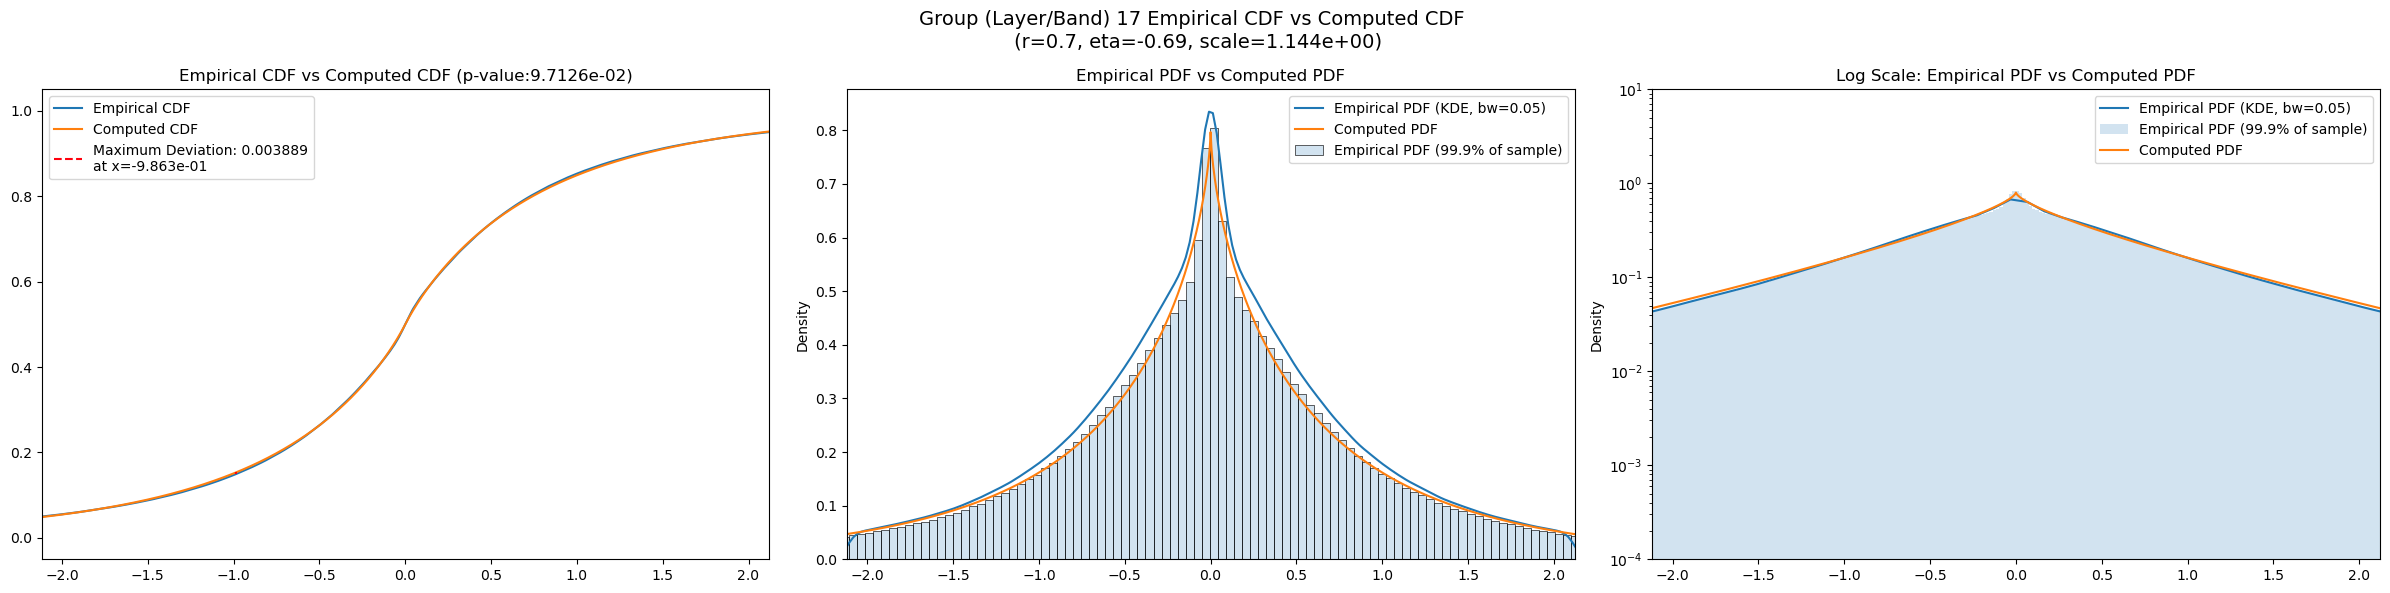

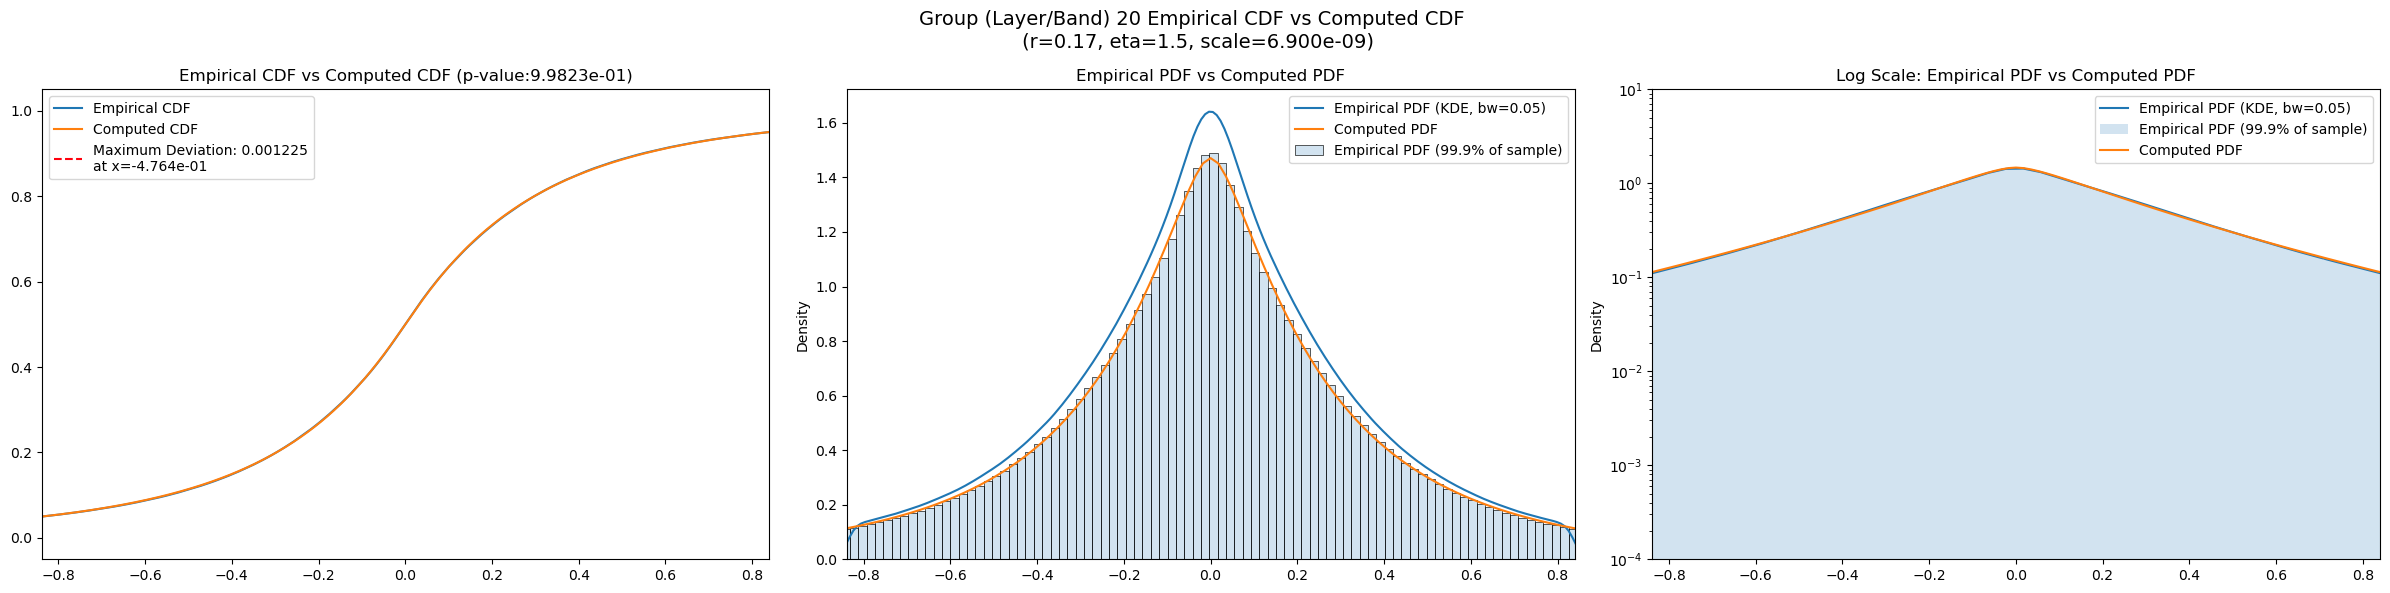

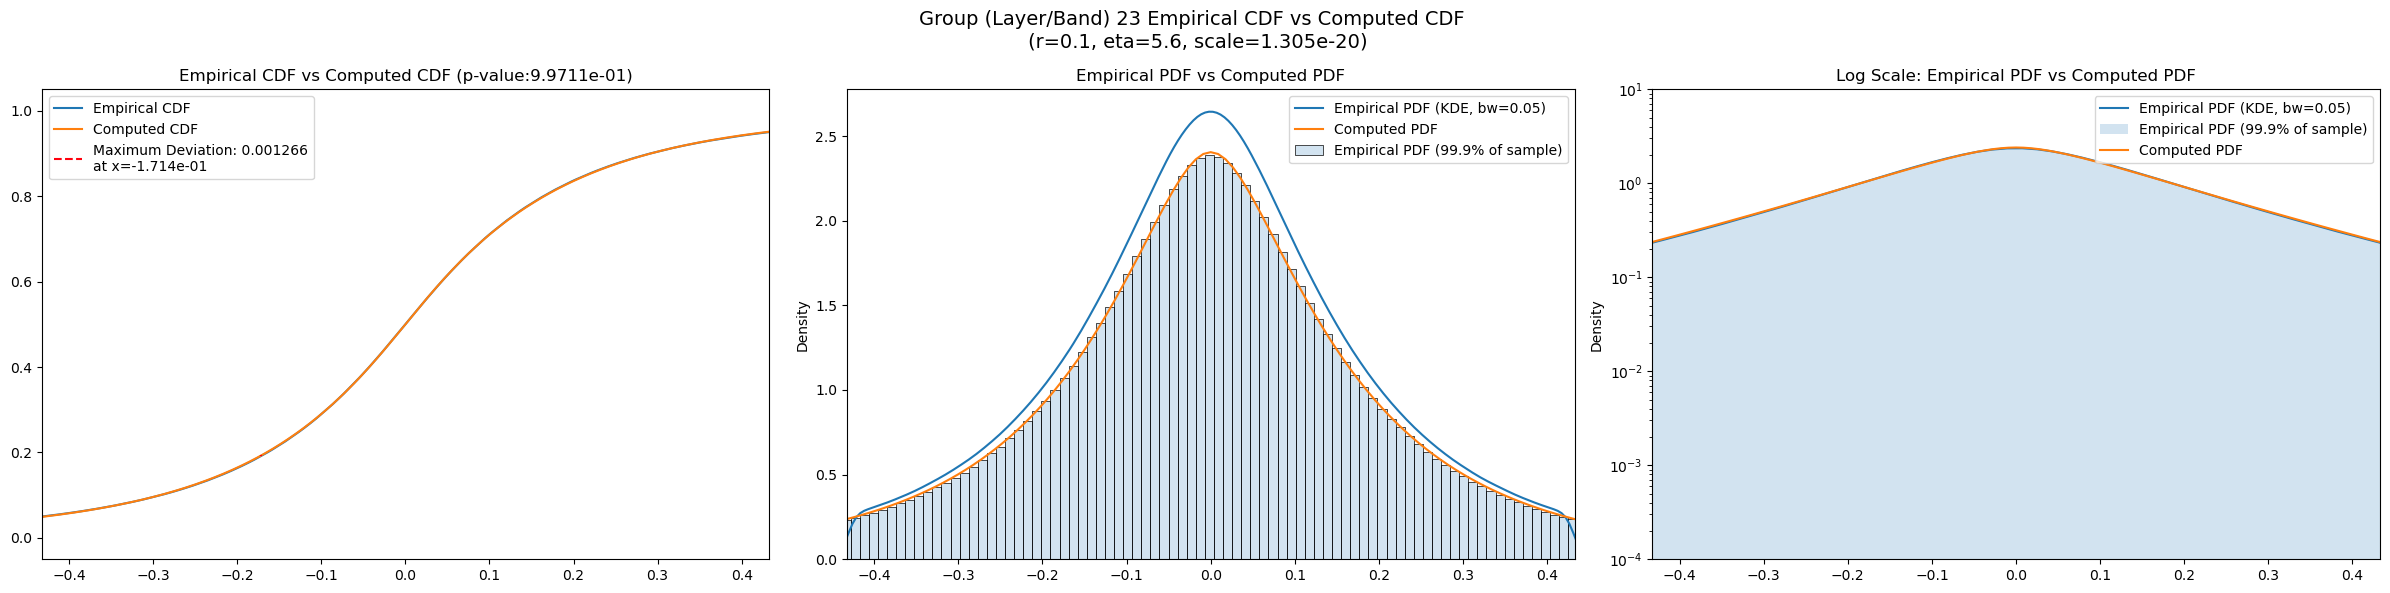

In [15]:
for group in GROUPS:
    group_info = master_df.loc[group]
    best_r = group_info['best_r']
    best_eta = group_info['best_eta']
    best_scale = group_info['best_scale']
    fig = visualize_cdf_pdf(sample = group_data_map[group], 
                    params = (best_r, best_eta, best_scale), 
                    log_scale = True,
                    group = group)
    fig.savefig(os.path.join(CWD, "plots", f'compare_cdf_pdf_layer_{group}.jpg'), bbox_inches = 'tight', dpi = 100)

## Comparing with Gaussian and Laplace Priors

In [16]:
def generate_func(sample, distro, *args, n_samples=200):
    if distro == 'gaussian' or distro == 'normal':
        def var_func(var):
            cdf = scipy.stats.norm(scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 'laplace':
        def var_func(var):
            cdf = scipy.stats.laplace(scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 't':
        def var_func(var):
            cdf = scipy.stats.t(df=2, scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 'prior_r':
        eta = args[0]
        def r_func(r):
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples)
            return compute_ksstat(sample, cdf)
        return r_func
    elif distro == 'prior_eta':
        r = args[0]
        def eta_func(eta):
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples)
            return compute_ksstat(sample, cdf)
        return eta_func
    elif distro == 'prior':
        def r_eta_func(params):
            r = params[0]
            eta = params[1]
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples, debug=False)
            return compute_ksstat(sample, cdf)
        return r_eta_func
    elif distro == 'prior_with_scale':
        def r_eta_scale_func(params):
            r = params[0]
            eta = params[1]
            scale = params[2]
            print(r, eta, scale)
            cdf = compute_prior_cdf(r = r, eta = eta, n_samples=n_samples, debug=False)
            return compute_ksstat(sample/ np.sqrt(scale), cdf)
        return r_eta_scale_func

    print("Please enter a valid argument for `distro`: 'gaussian', 'laplace', 'prior_r', 'prior_eta', 'prior','prior_with_scale', 't'")

In [17]:
master_df_path = Path(os.path.join(CWD, "CSVs", 'master_df.csv'))

if RERUN or not master_df_path.exists():
    upper_bound = int(1e6)
    for group in GROUPS:
        norm_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 'gaussian'), method = 'bounded', bounds = (0, upper_bound))
        laplace_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 'laplace'), method = 'bounded', bounds = (0, upper_bound))
        t_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 't'), method = 'bounded', bounds = (0, upper_bound))
        
        master_df.loc[group, 'param_gaussian'] = round_to_sigfigs(norm_result['x'], 6)
        master_df.loc[group, 'kstest_stat_gaussian'] = round_to_sigfigs(norm_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_gaussian'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_gaussian']), 6)

        master_df.loc[group, 'param_laplace'] = round_to_sigfigs(laplace_result['x'], 6)
        master_df.loc[group, 'kstest_stat_laplace'] = round_to_sigfigs(laplace_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_laplace'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_laplace']), 6)

        master_df.loc[group, 'param_laplace'] = round_to_sigfigs(laplace_result['x'], 6)
        master_df.loc[group, 'kstest_stat_laplace'] = round_to_sigfigs(laplace_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_laplace'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_laplace']), 6) 

        master_df.loc[group, 'param_t'] = round_to_sigfigs(t_result['x'], 6)
        master_df.loc[group, 'kstest_stat_t'] = round_to_sigfigs(t_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_t'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_t']), 6) 

        master_df.loc[group, 'kstest_pval_gengamma'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_best']))

    master_df.to_csv(os.path.join(CWD, "CSVs", 'master_df.csv'))
    
master_df = pd.read_csv(os.path.join(CWD, "CSVs", 'master_df.csv'), index_col = GROUP)
master_df

obs_var    var_lower    var_upper    obs_kurt  kurt_lower  \
band                                                                  
2     1168.482900  1082.486900  1261.638700    6.890563    4.571610   
5      467.177500   422.133970   521.637700   15.030487    7.136231   
8      126.599790   114.962166   140.439400   12.860019    6.715555   
11      29.448475    26.871750    32.462646   11.616289    6.209942   
14       8.483740     7.724014     9.536135   14.224842    6.182292   
17       2.096802     1.867217     2.664229   44.881523    6.934429   
20       0.361453     0.299279     0.666267  406.070500    7.254397   
23       0.083664     0.074874     0.111109   64.435370    4.880280   

       kurt_upper  total_samples  kstest_stat_initial  initial_r  initial_eta  \
band                                                                            
2        9.890165        47614.0             0.006307        2.6         -0.9   
5       30.144716       102030.0             0.008226        1.3         -0.9   
8       27.600851       326496.0             0.006995        1.3         -0.9   
11      26.865057       904666.0             0.006396        1.6         -0.9   
14      52.539310      2727602.0             0.005406        1.3         -0.9   
17     256.248660      8298440.0             0.004133        0.6         -0.6   
20    1292.889300     25140192.0             0.001855        0.2          1.1   
23     358.102840     65734528.0             0.001626        0.1          5.6   

      ...  param_gaussian  kstest_stat_gaussian  kstest_pval_gaussian  \
band  ...                                                               
2     ...       24.807600              0.035071          2.556660e-51   
5     ...       14.395900              0.038778         9.552010e-134   
8     ...        7.501900              0.038661          0.000000e+00   
11    ...        3.685800              0.037614          0.000000e+00   
14    ...        1.934920              0.039890          0.000000e+00   
17    ...        0.946427              0.038914          0.000000e+00   
20    ...        0.386916              0.035723          0.000000e+00   
23    ...        0.212717              0.029535          0.000000e+00   

      param_laplace  kstest_stat_laplace  kstest_pval_laplace    param_t  \
band                                                                       
2         20.830500             0.012682         4.426920e-07  17.470100   
5         12.179500             0.014545         3.536980e-19  10.017500   
8          6.400420             0.013946         1.379110e-55   5.179750   
11         3.124540             0.013636        1.491570e-146   2.540290   
14         1.677300             0.013866         0.000000e+00   1.333500   
17         0.829224             0.012295         0.000000e+00   0.654958   
20         0.341342             0.009520         0.000000e+00   0.273138   
23         0.184124             0.005128         0.000000e+00   0.150663   

      kstest_stat_t  kstest_pval_t  kstest_pval_gengamma  
band                                                      
2          0.017813   1.489020e-13          4.511215e-02  
5          0.017676   4.031720e-28          5.503608e-06  
8          0.016843   6.906370e-81          7.580612e-13  
11         0.016499  2.427080e-214          7.910331e-30  
14         0.016788   0.000000e+00          9.503170e-58  
17         0.015440   0.000000e+00          2.757107e-91  
20         0.009374   0.000000e+00          1.286209e-45  
23         0.006043   0.000000e+00         2.073689e-151  

[8 rows x 30 columns]

## Results

In [18]:
import pandas as pd
import os
master_df = pd.read_csv(os.path.join(os.getcwd(), "CSVs", 'master_df.csv'), index_col = 0)

In [19]:
master_df.filter(regex="kstest_stat.*")

kstest_stat_initial  kstest_stat_cutoff_0.05  kstest_stat_best  \
band                                                                   
2                0.006307                 0.006220          0.006307   
5                0.008226                 0.004250          0.007919   
8                0.006995                 0.002376          0.006618   
11               0.006396                 0.001428          0.006117   
14               0.005406                 0.000822          0.004919   
17               0.004133                 0.000471          0.003550   
20               0.001855                 0.000271          0.001439   
23               0.001626                 0.000168          0.001626   

      kstest_stat_gaussian  kstest_stat_laplace  kstest_stat_t  
band                                                            
2                 0.035071             0.012682       0.017813  
5                 0.038778             0.014545       0.017676  
8                 0.038661             0.013946       0.016843  
11                0.037614             0.013636       0.016499  
14                0.039890             0.013866       0.016788  
17                0.038914             0.012295       0.015440  
20                0.035723             0.009520       0.009374  
23                0.029535             0.005128       0.006043

In [20]:
master_df.filter(regex="best.*")

best_augmented_var  kstest_stat_best  best_r  best_eta    best_scale  \
band                                                                         
2            1038.464700          0.006307    2.60     -0.90  2.816371e+03   
5             384.246918          0.007919    1.60     -0.92  9.364447e+02   
8             101.942039          0.006618    1.50     -0.92  2.409038e+02   
11             23.272135          0.006117    1.90     -0.92  6.046584e+01   
14              6.997544          0.004919    1.10     -0.87  1.228633e+01   
17              1.739281          0.003550    0.70     -0.69  1.144466e+00   
20              0.312110          0.001439    0.17      1.50  6.900204e-09   
23              0.077943          0.001626    0.10      5.60  1.304527e-20   

      best_exclude_cutoff  
band                       
2                    75.0  
5                   200.0  
8                   275.0  
11                  350.0  
14                  250.0  
17                  175.0  
20                   25.0  
23                   25.0

In [21]:
eng.quit()